# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB simulation 

## Thalamocortical Wilson - Cowan like TVB mean field model [4]


For every cortical region node $n\prime$ modelled as a mean-field node in TVB:

- Population activity dynamics of 1 excitatory and 1 inhibitory cortical populations:

$\dot{E}_{n\prime} = \dfrac{1}{\tau_e} (- E_{n\prime}  
                                + w_{ee} \mathcal{Sigm}(E_{n\prime}  ) 
                                + w_{ie} \mathcal{Sigm}(I_{n\prime}) 
                                + w_{se} \mathcal{Sigm}(S_{n\prime}(t - \tau_{ct}))
                                + G*\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\}
                                + I_e
                                )$
 
$\dot{I}_{n\prime} = \dfrac{1}{\tau_i} (- I_{n\prime}  
                                + w_{ei} \mathcal{Sigm}(E_{n\prime}  ) 
                                + w_{ii} \mathcal{Sigm}(I_{n\prime}) 
                                + w_{si} \mathcal{Sigm}(S_{n\prime}(t - \tau_{ct}))
                                + I_i
                                )$
                                
- Population activity dynamics of 1 inhibitory reticular and 1 excitatory relay thalamic nuclei:

$\dot{R}_{n\prime} = \dfrac{1}{\tau_r} (- R_{n\prime}  
                                + w_{er} \mathcal{Sigm}(E_{n\prime}(t - \tau_{ct})) 
                                + w_{sr} \mathcal{Sigm}(S_{n\prime}(t - \tau_{tt})) 
                                + I_r
                                )$
                                
$\dot{S}_{n\prime} = \dfrac{1}{\tau_s} (- S_{n\prime}  
                                + w_{es} \mathcal{Sigm}(E_{n\prime}(t - \tau_{ct})) 
                                + w_{rs} \mathcal{Sigm}(R_{n\prime}(t - \tau_{tt})) 
                                + I_s
                                + I_{s_{n\prime}}(t)
                                )$
                                
                                
For every subcortical region node $n\prime$ modelled as a mean-field node in TVB:      

- Population activity dynamics of 1 excitatory and 1 inhibitory cortical populations:

$\dot{E}_{n\prime} = \dfrac{1}{\tau_e} (- E_{n\prime}  
                                + w_{ee} \mathcal{Sigm}(E_{n\prime}  ) 
                                + w_{ie} \mathcal{Sigm}(I_{n\prime}) 
                                + G*\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\}
                                + I_e
                                + I_{e_{n\prime}}(t)
                                )$
 
$\dot{I}_{n\prime} = \dfrac{1}{\tau_i} (- I_{n\prime}  
                                + w_{ei} \mathcal{Sigm}(E_{n\prime}  ) 
                                + w_{ii} \mathcal{Sigm}(I_{n\prime}) 
                                + I_i
                                )$

- No thalamocortical loop!:

$\dot{R}_{n\prime} = \dfrac{1}{\tau_r} (- R_{n\prime})$
                                
$\dot{S}_{n\prime} = \dfrac{1}{\tau_s} (- S_{n\prime})$


For BOLD, we record the postsynaptic firing rate activity of $E$ as an extra, non-integrated state variable $A$:

${A}_{n\prime} = w_{ee} \mathcal{Sigm}(E_{n\prime}  ) 
                + w_{ie} \mathcal{Sigm}(I_{n\prime}) 
                + w_{se} \mathcal{Sigm}(S_{n\prime}(t - \tau_{ct}))
                + G*\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\}
                + I_e$
                
                
In all cases, we use the same sigmoidal activation function:

$ Sigm(x) = \frac{1}{1+e^{-\beta(x - \sigma)}} $

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

# ----------- Simulation options ----------------
TEST = True
G = 135.0 # 50.0 * 200/80  # in Griffiths et al paper = 5.0
I_o = 1.0
STIMULUS = True
DEMO = False # To simulate disconnected Griffiths' et al like thalamocortical nodes for alpha + gamma bands
THAL_CRTX_VAR = "wd" # , "w", "d" or False, in order to spread values of thalamocortical Weights, Delays, or both, or not
BRAIN_CONNECTIONS_TO_SCALE = [] # e.g., [["Region 1", ["Region 2", "Region 3"], scaling_factor]]
# -----------------------------------------------

BRAIN_CONN_FILE = "Connectivity_SummedSubcortical.h5" # "Connectivity_SummedSubcortical.h5", Connectivity_res100_summ49regions_IOsplit.h5"
MAJOR_STRUCTS_LABELS_FILE = "major_structs_labels_SummedSubcortical.npy"
VOXEL_COUNT_FILE = "voxel_count_SummedSubcortical.npy"
INDS_FILE = "inds_SummedSubcortical.npy"

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data", "cerebellum")
tvb_conn_filepath = os.path.join(data_path, BRAIN_CONN_FILE)
outputs_path = os.path.join(work_path, "outputs/cereb_wilson_cowan")
outputs_path += '_G%g' % G
outputs_path += '_Io%g' % I_o
outputs_path += "_TVBonly"
outputs_path += "_%s" % (BRAIN_CONN_FILE.split("Connectivity_")[-1].split(".h5")[0])
if THAL_CRTX_VAR:
    outputs_path += "_THAL_CRTX_VAR%s" % THAL_CRTX_VAR.upper()
if STIMULUS:
    outputs_path += "_Stim" 
if DEMO:
    outputs_path += "_demo"
print("Outputs' path: %s" % outputs_path)

config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

NOISE = 1e-6 # config.DEFAULT_NSIG = 0.001

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline


2022-02-04 16:44:13,261 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-02-04 16:44:13,261 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-02-04 16:44:13,266 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-02-04 16:44:13,266 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-02-04 16:44:13,270 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-02-04 16:44:13,270 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-02-04 16:44:13,275 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-02-04 16:44:13,275 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-02-04 16:44:13,280 - INFO - tvb_multiscale.tv

Outputs' path: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cereb_wilson_cowan_G135_Io1_TVBonly_SummedSubcortical_THAL_CRTX_VARWD_Stim



## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
dt = config.DEFAULT_DT  # =0.1

In [3]:
import h5py
f = h5py.File(tvb_conn_filepath)
centres=np.array(f["centres"][()]) # hemispheres=np.array(f["hemispheres"][()]), 
region_labels=np.array(f["region_labels"][()]).astype("<U128")
weights=np.array(f["weights"][()])
tract_lengths=np.array(f["tract_lengths"][()]) 
f.close()

major_structs_labels = np.load(os.path.join(data_path, MAJOR_STRUCTS_LABELS_FILE))
voxel_count = np.load(os.path.join(data_path, VOXEL_COUNT_FILE))
inds = np.load(os.path.join(data_path, INDS_FILE), allow_pickle=True).item()
print(inds)

{'crtx': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121]), 'm1': array([ 1, 80]), 's1brl': array([ 4, 83]), 'supcol': array([ 52,  52, 131, 131]), 'facial': array([ 59, 138]), 'trigeminal': array([ 58, 137]), 'ponssens_trigeminal': array([ 54, 133]), 'ponssens': array([ 53,  54, 132, 133]), 'ponsmotor': array([ 55, 134]), 'thal': array([ 49, 128]), 'thalspec': array([ 48,  49, 127, 128]), 'm1thal': array([], dtype=float64), 's1brlthal': array([], dtype=float64), 'ansilob': array([ 70, 149]), 'dentate': array([ 77, 156]), 'interposed': array([ 76, 155]), 'oliv': a

In [4]:
# Find thalamic index:
inds["subcrtx"] = np.arange(len(region_labels)).astype('i')
inds["subcrtx"] = np.delete(inds["subcrtx"], inds["crtx"])
is_cortical = np.array([False] * region_labels.shape[0]).astype("bool")
is_cortical[inds["crtx"]] = True


In [5]:
from tvb.datatypes.connectivity import Connectivity

# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

connectivity = Connectivity(centres=centres, region_labels=region_labels, 
                            weights=weights, tract_lengths=tract_lengths)

# Selectively scale up some connections, if required:
for reg1, reg2, sc in BRAIN_CONNECTIONS_TO_SCALE:
    iR1 = np.where([reg in reg1 for reg in connectivity.region_labels])[0]
    iR2 = np.where([reg in reg2 for reg in connectivity.region_labels])[0]
    connectivity.weights[iR1, iR2] *= sc
    
# Normalize connectivity weights
connectivity.weights[np.isnan(connectivity.weights)] = 0.0
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.tract_lengths = np.maximum(connectivity.speed * dt, 
                                        connectivity.tract_lengths)

connectivity.configure()

# Plot TVB connectome:
# plotter.plot_tvb_connectivity(connectivity);


In [6]:

# -----------------------------------Build cosimulator manually--------------------------------
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial

simulator = CoSimulatorSerial()

simulator.connectivity = connectivity

dummy_shape = (simulator.connectivity.number_of_regions, )


In [7]:
from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import GriffithsThalamoCortical
from examples.tvb_nest.notebooks.cerebellum.utils import print_conn


# G normalized by the number of regions as in Griffiths et al paper
model_params = {"G": np.array([G])/simulator.connectivity.number_of_regions, 
                'I_o': np.array([I_o])}
if DEMO:
    model_params.update({'G': model_params["G"],
                         'w_ee': np.array([1.4]), 
                         'w_ei': np.array([1.4]), 
                         'w_ie': np.array([-3.0]), 
                         'tau_e': np.array([10.0/0.9]), 
                         'tau_i': np.array([10.0/0.9]),
                         'tau_s': np.array([10.0/0.25]), 
                         'tau_r': np.array([10.0/0.25])
                        })
    
if STIMULUS:
    M_e = np.zeros(dummy_shape).astype("f")
    f_e = np.zeros(dummy_shape).astype("f")
    M_s = np.zeros(dummy_shape).astype("f")
    f_s = np.zeros(dummy_shape).astype("f")
    # Stimuli:
    if TEST:
        # Stimuli:
        M_s[inds["m1"]] = 1.0
        f_s[inds["m1"]] = 6.0 # Hz
    else:
        # Sensory to Medulla SPV
        M_e[inds["trigeminal"]] = 1.0
        f_e[inds["trigeminal"]] = 6.0 # Hz
        # Motor to Facial nucleus
        M_e[inds["facial"]] = 1.0
        f_e[inds["facial"]] = 6.0 # Hz
    model_params.update({"M_e": M_e, "M_s": M_s, "f_e": f_e, "f_s": f_s})

simulator.model = GriffithsThalamoCortical(is_cortical=is_cortical[:, np.newaxis], **model_params)
simulator.model.dt = dt
simulator.model.test_mode = TEST

# Variability to thalamocortical connections:
if THAL_CRTX_VAR:
    
    from scipy.stats import zscore
    n_crtx2 = int(len(inds["crtx"])/2)

    def scaler(x, var=1.0):
        assert var <= 1.0
        y = zscore(x, axis=0, ddof=0, nan_policy='omit')
        y /= np.abs(y).max()
        y[np.isnan(y)] = 0.0
        return var*y

    def scale(x, sc):
        return (1 + sc) * x

    # weights:
    if "w" in THAL_CRTX_VAR:
        w_thal_to_crtx_right_zs = scaler(simulator.connectivity.weights[inds["crtx"][:n_crtx2], inds["thal"][0]])
        w_thal_to_crtx_left_zs = scaler(simulator.connectivity.weights[inds["crtx"][n_crtx2:], inds["thal"][1]])
        w_crtx_to_thal_right_zs = scaler(simulator.connectivity.weights[inds["thal"][0], inds["crtx"][:n_crtx2]])
        w_crtx_to_thal_left_zs = scaler(simulator.connectivity.weights[inds["thal"][1], inds["crtx"][n_crtx2:]])
        simulator.model.w_se = simulator.model.w_se * np.ones(dummy_shape)
        simulator.model.w_si = simulator.model.w_si * np.ones(dummy_shape)
        simulator.model.w_er = simulator.model.w_er * np.ones(dummy_shape)
        simulator.model.w_es = simulator.model.w_es  * np.ones(dummy_shape)
        simulator.model.w_se[inds["crtx"][:n_crtx2]] = scale(simulator.model.w_se[inds["crtx"][:n_crtx2]], 
                                                             w_thal_to_crtx_right_zs)
        simulator.model.w_si[inds["crtx"][:n_crtx2]] = scale(simulator.model.w_si[inds["crtx"][:n_crtx2]],
                                                             w_thal_to_crtx_right_zs)
        simulator.model.w_se[inds["crtx"][n_crtx2:]] = scale(simulator.model.w_se[inds["crtx"][n_crtx2:]],
                                                             w_thal_to_crtx_left_zs)
        simulator.model.w_si[inds["crtx"][n_crtx2:]] = scale(simulator.model.w_si[inds["crtx"][n_crtx2:]],
                                                             w_thal_to_crtx_left_zs)
        simulator.model.w_er[inds["crtx"][:n_crtx2]] = scale(simulator.model.w_er[inds["crtx"][:n_crtx2]],
                                                             w_crtx_to_thal_right_zs)
        simulator.model.w_es[inds["crtx"][:n_crtx2]] = scale(simulator.model.w_es[inds["crtx"][:n_crtx2]],
                                                             w_crtx_to_thal_right_zs)
        simulator.model.w_er[inds["crtx"][n_crtx2:]] = scale(simulator.model.w_er[inds["crtx"][n_crtx2:]],
                                                             w_crtx_to_thal_left_zs)
        simulator.model.w_es[inds["crtx"][n_crtx2:]] = scale(simulator.model.w_es[inds["crtx"][n_crtx2:]], 
                                                             w_crtx_to_thal_left_zs)
    # delays:
    if "d" in THAL_CRTX_VAR:
        d_thal_to_crtx_right_zs = scaler(simulator.connectivity.tract_lengths[inds["crtx"][:n_crtx2], inds["thal"][0]] / 
                                          simulator.connectivity.speed)
        d_thal_to_crtx_left_zs = scaler(simulator.connectivity.tract_lengths[inds["crtx"][n_crtx2:], inds["thal"][1]] / 
                                         simulator.connectivity.speed)
        simulator.model.tau_ct = simulator.model.tau_ct * np.ones(dummy_shape)
        simulator.model.tau_ct[inds["crtx"][:n_crtx2]] = scale(simulator.model.tau_ct[inds["crtx"][:n_crtx2]],
                                                               d_thal_to_crtx_right_zs)
        simulator.model.tau_ct[inds["crtx"][n_crtx2:]] = scale(simulator.model.tau_ct[inds["crtx"][n_crtx2:]],
                                                               d_thal_to_crtx_left_zs)
        simulator.model.tau_ct[inds["crtx"]] = np.round(simulator.model.tau_ct[inds["crtx"]] 
                                                        / simulator.model.dt) * simulator.model.dt

    d = OrderedDict()
    d[("Region", 55)] = ["%d.%s" % (iR, reg) for iR, reg in enumerate(region_labels[inds["crtx"]])]
    d[("w_se(%g)" % simulator.model.w_se[-1], 12)] = simulator.model.w_se[inds["crtx"]]
    d[("w_si(%g)" % simulator.model.w_si[-1], 12)] = simulator.model.w_si[inds["crtx"]]
    d[("w_er(%g)" % simulator.model.w_er[-1], 12)] = simulator.model.w_er[inds["crtx"]]
    d[("w_es(%g)" % simulator.model.w_es[-1], 12)] = simulator.model.w_es[inds["crtx"]]
    d[("tau_ct(%g)" % simulator.model.tau_ct[-1], 12)] = simulator.model.tau_ct[inds["crtx"]]

    print_conn(d, 
               prnt="", printit=True);

# # Homogenize crtx <-> subcrtx connnectivity
# simulator.connectivity.weights[inds["crtx"][:, None], inds["subcrtx"][None, :]] = 0.0 # 0.008
# simulator.connectivity.weights[inds["subcrtx"][:, None], inds["crtx"][None, :]] = 0.0 # 0.008


Region.................................................w_se(1.65)..w_si(0.2)...w_er(0.6)...w_es(0.6)...tau_ct(20)..
-------------------------------------------------------------------------------------------------------------------
0.Right Frontal pole, cerebral cortex..................1.65198.....0.20024.....0.985558....0.985558....34.5........
1.Right Primary motor area.............................1.30942.....0.158717....0.812632....0.812632....14.2........
2.Right Secondary motor area...........................1.45305.....0.176127....0.844929....0.844929....20.6........
3.Right Primary somatosensory area, nose...............1.197.......0.145091....0.523339....0.523339....16.6........
4.Right Primary somatosensory area, barrel field.......1.22825.....0.148878....0.464465....0.464465....16.8........
5.Right Primary somatosensory area, lower limb.........1.25837.....0.15253.....0.706242....0.706242....11.6........
6.Right Primary somatosensory area, mouth..............1.2278......0.148

In [8]:
from tvb.simulator.integrators import EulerStochastic, HeunStochastic
from tvb.simulator.monitors import Raw, Bold # , EEG
from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import SigmoidalPre


simulator.coupling = SigmoidalPre(sigma=np.array([1.0]),
                                  midpoint=simulator.model.sigma, 
                                  cmin=np.array([0.0]), 
                                  cmax=np.array([1.0]), 
                                  a=simulator.model.beta) 

simulator.integrator = HeunStochastic() # EulerStochastic() # HeunStochastic()
simulator.integrator.dt = dt
simulator.integrator.noise.nsig = np.array([NOISE] * (simulator.model.nvar-1) + [0.0])

simulator.initial_conditions = np.zeros((1000, simulator.model.nvar, connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
bold = Bold(period=128.0, variables_of_interest=np.array([4]))  # !!! Set a proper (1-2 sec??) TR time in ms !!!
simulator.monitors = (mon_raw, bold)
simulator.configure()

simulator.integrate_next_step = simulator.integrator.integrate_with_update

simulator.print_summary_info_details(recursive=1)


CoSimulatorSerial (
  title ........................... 'CoSimulatorSerial gid: 0f9751c0-3438-4d08-bd2e-f5185a7b7478'
  Type ............................ 'CoSimulatorSerial'
  model ........................... GriffithsThalamoCortical gid: 36463131-d3a3-4181-b992-7e5de1db71bf
  output_interfaces ............... None
  input_interfaces ................ None
  exclusive ....................... False
  voi ............................. --------------------
  shape ........................... (0,)
  dtype ........................... int64
  is empty ........................ True
  proxy_inds ...................... --------------------
  synchronization_time ............ 0.0
  connectivity .................... Connectivity gid: 904306fe-4079-41a7-ad27-8251593988f3
  conduction_speed ................ 3.0
  coupling ........................ SigmoidalPre gid: a2f0d215-8642-411b-a84c-540265005f66
  surface ......................... None
  stimulus ........................ None
  integrator ....

## 4. Configure simulator, simulate, gather results

In [9]:
# Simulate!

# Set the simulation time:
simulation_length =  1124.0  # for reasonable resting state, use about 1 min = 60 sec = 60000.0 ms + transient
transient = 100.0 # 0.1 * simulation_length    
simulator.simulation_length = simulation_length

tic = time.time()
results = simulator.run()
print("\nSimulated in %f secs!" % (time.time() - tic))



Simulated in 112.203693 secs!


## 5. Plot results and write them to HDF5 files

In [10]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [11]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
bold_ts = None

if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion(data=source_ts._data,
                                                connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    print("Raw ts:\n%s" % str(source_ts))
    
    if len(results) > 1:
        bold_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
                data=results[1][1], time=results[1][0],
                connectivity=simulator.connectivity,
                labels_ordering=["Time", "State Variable", "Region", "Neurons"],
                labels_dimensions={"State Variable": ["BOLD"],
                                   "Region": simulator.connectivity.region_labels.tolist()})
        bold_ts.configure()

        bold_t = source_ts.time

        # Write to file
        if writer:
            writer.write_tvb_to_h5(TimeSeriesRegion(data=bold_ts._data,
                                                    connectivity=bold_ts.connectivity),
                                   os.path.join(config.out.FOLDER_RES, bold_ts.title)+".h5")
        print("BOLD ts:\n%s" % str(bold_ts))
    

Raw ts:
TimeSeriesRegion (
  Dimensions .......... ['Time', 'State Variable', 'Region', 'Neurons']
  Length .............. 11240
  Region Mapping ...... None
  Region Mapping Volume  None
  Sample period ....... 0.1
  Source Connectivity . Connectivity gid: 904306fe-4079-41a7-ad27-8251593988f3
  Time units .......... ms
  Time-series name .... Region Time Series
  Time-series type .... TimeSeriesRegion
  [min, median, max] .. [-1.26338, 0.0338914, 173.503]
  dtype ............... float64
  shape ............... (11240, 5, 158, 1)
)
BOLD ts:
TimeSeriesRegion (
  Dimensions .......... ['Time', 'State Variable', 'Region', 'Neurons']
  Length .............. 9
  Region Mapping ...... None
  Region Mapping Volume  None
  Sample period ....... 128.0
  Source Connectivity . Connectivity gid: 904306fe-4079-41a7-ad27-8251593988f3
  Time units .......... ms
  Time-series name .... Region Time Series
  Time-series type .... TimeSeriesRegion
  [min, median, max] .. [-0.771914, -0.0797786, 481.799]


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


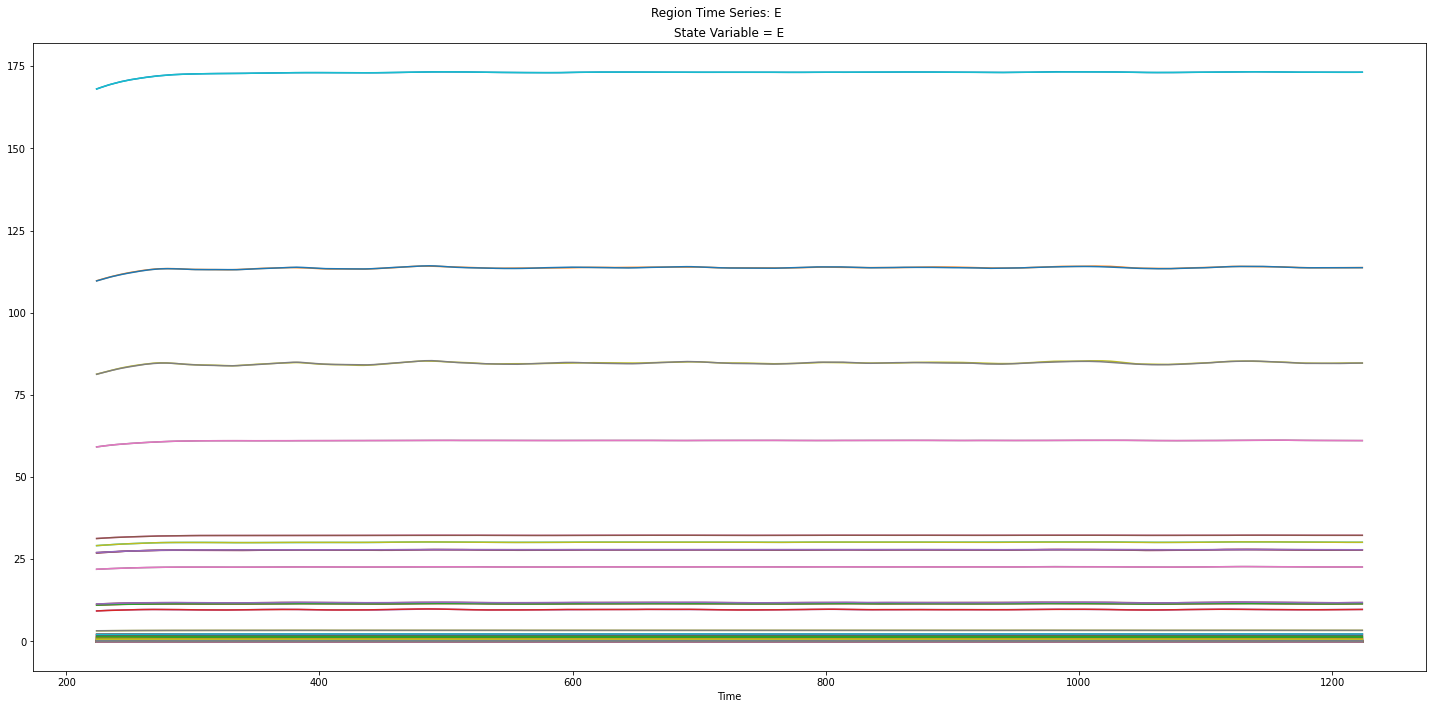

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


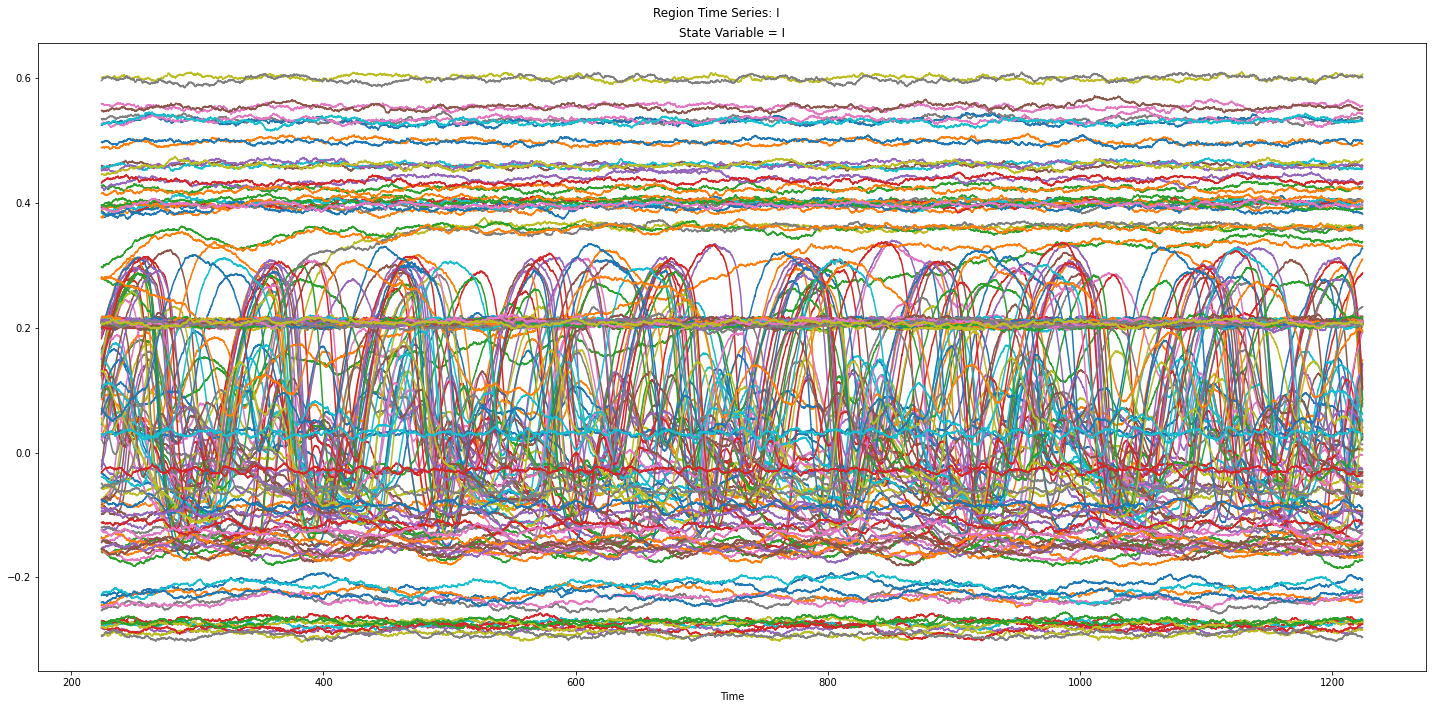

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


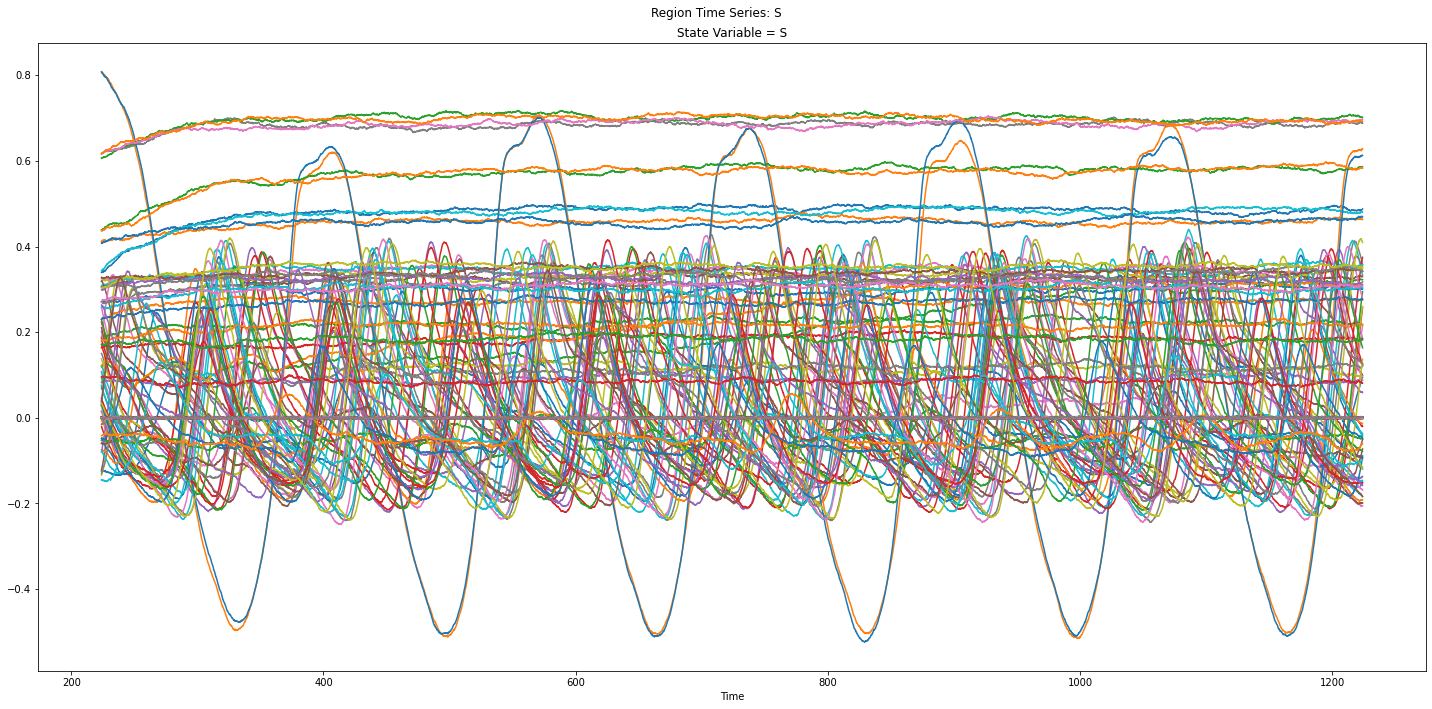

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


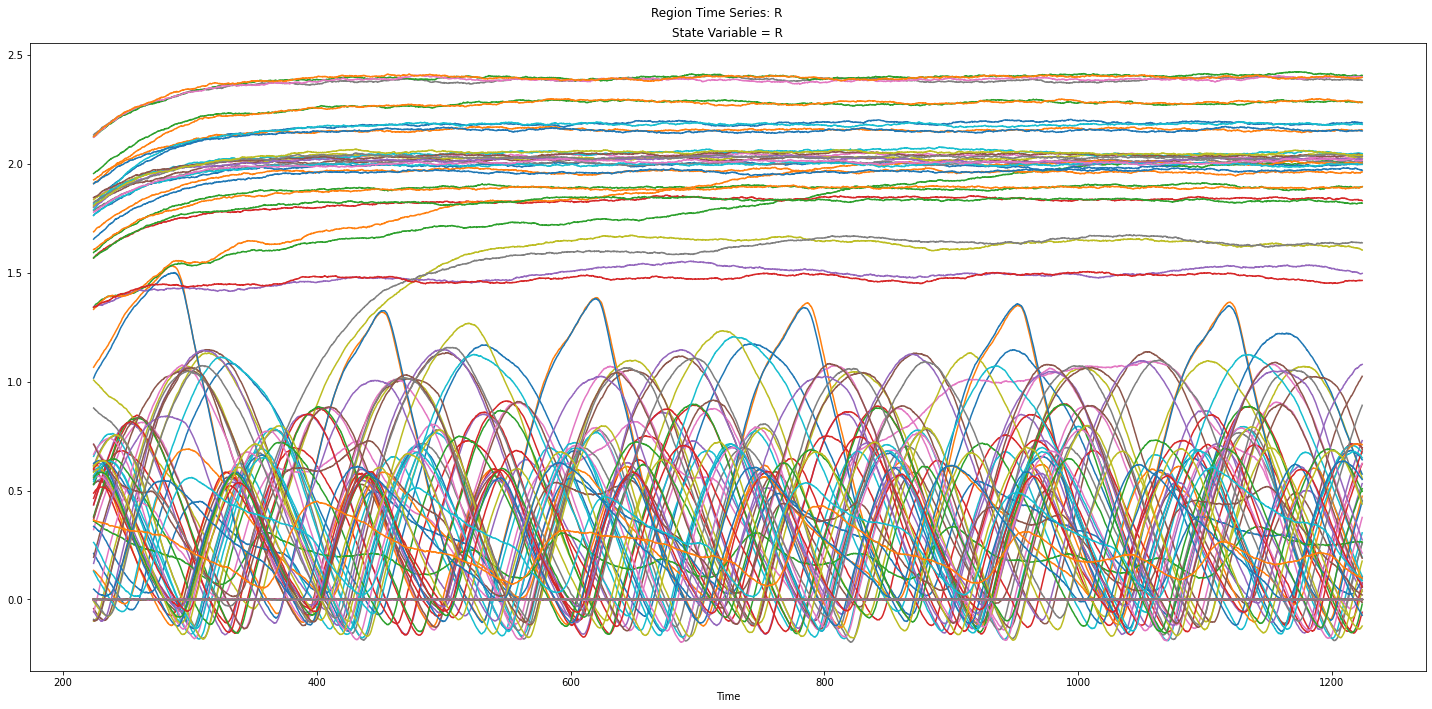

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


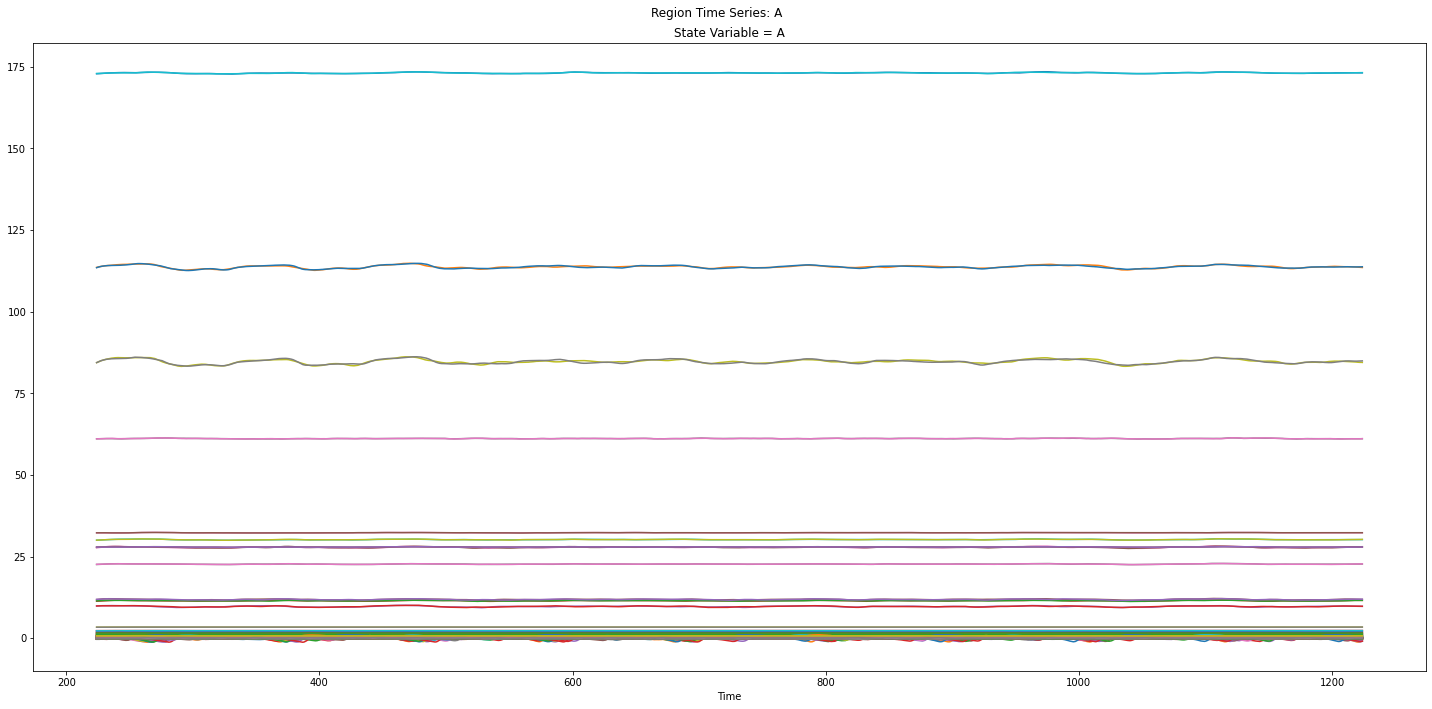

In [12]:
# Plot TVB time series
if source_ts is not None:
    source_ts[-10000:].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

2022-02-04 16:46:17,064 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:17,084 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


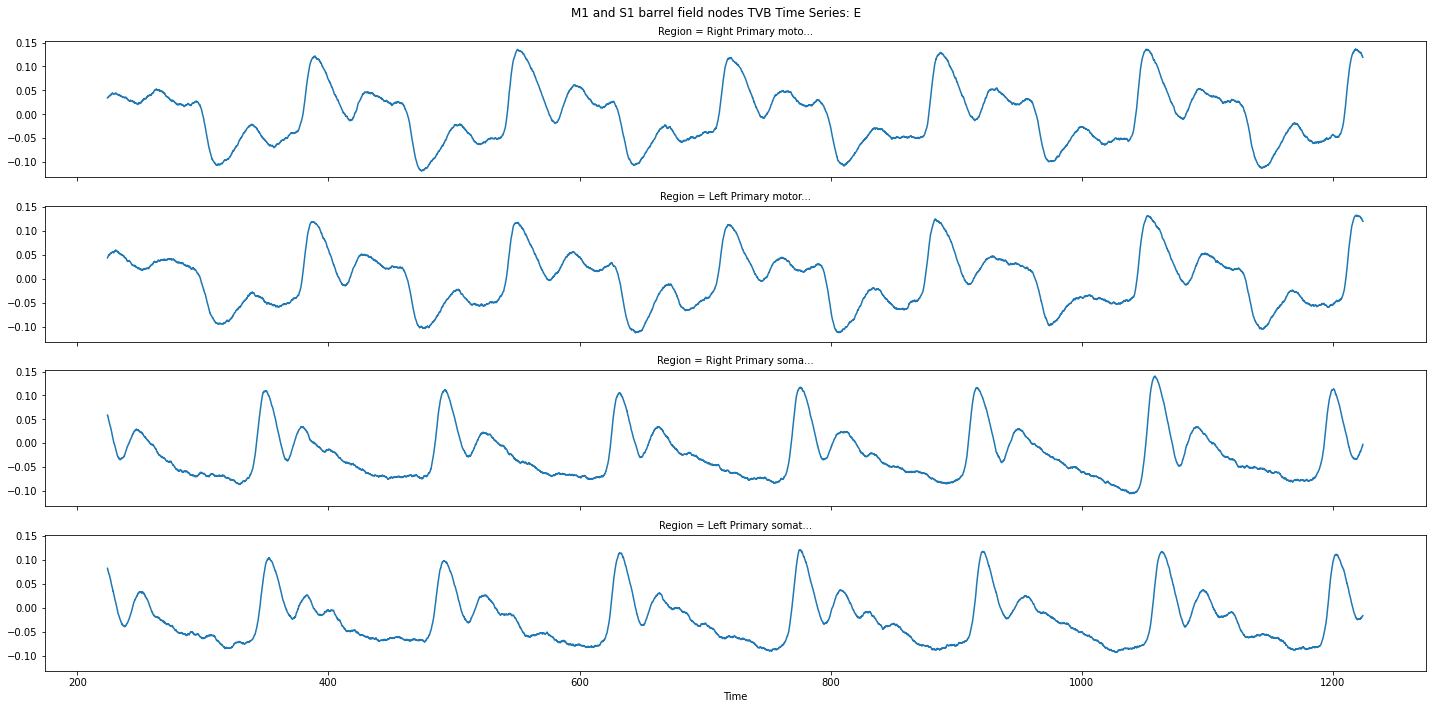

2022-02-04 16:46:18,006 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


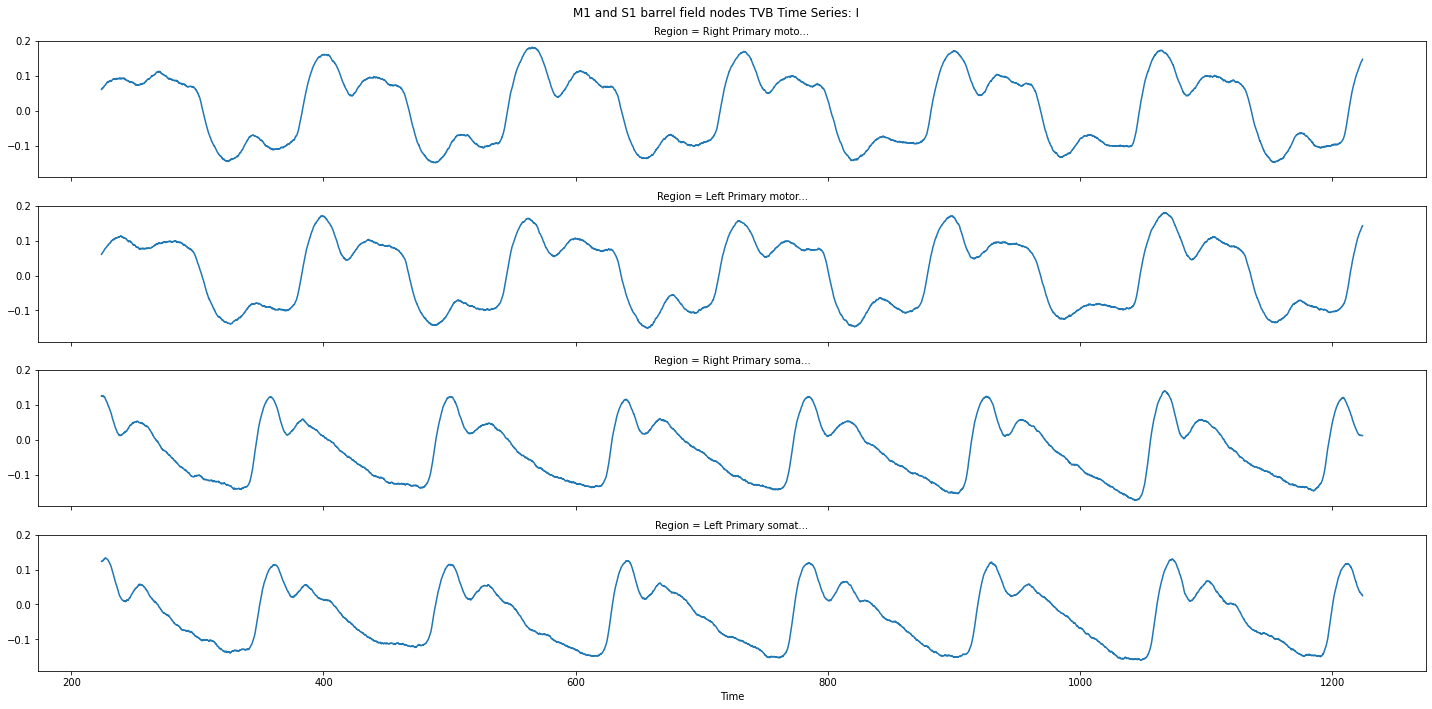

2022-02-04 16:46:18,794 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


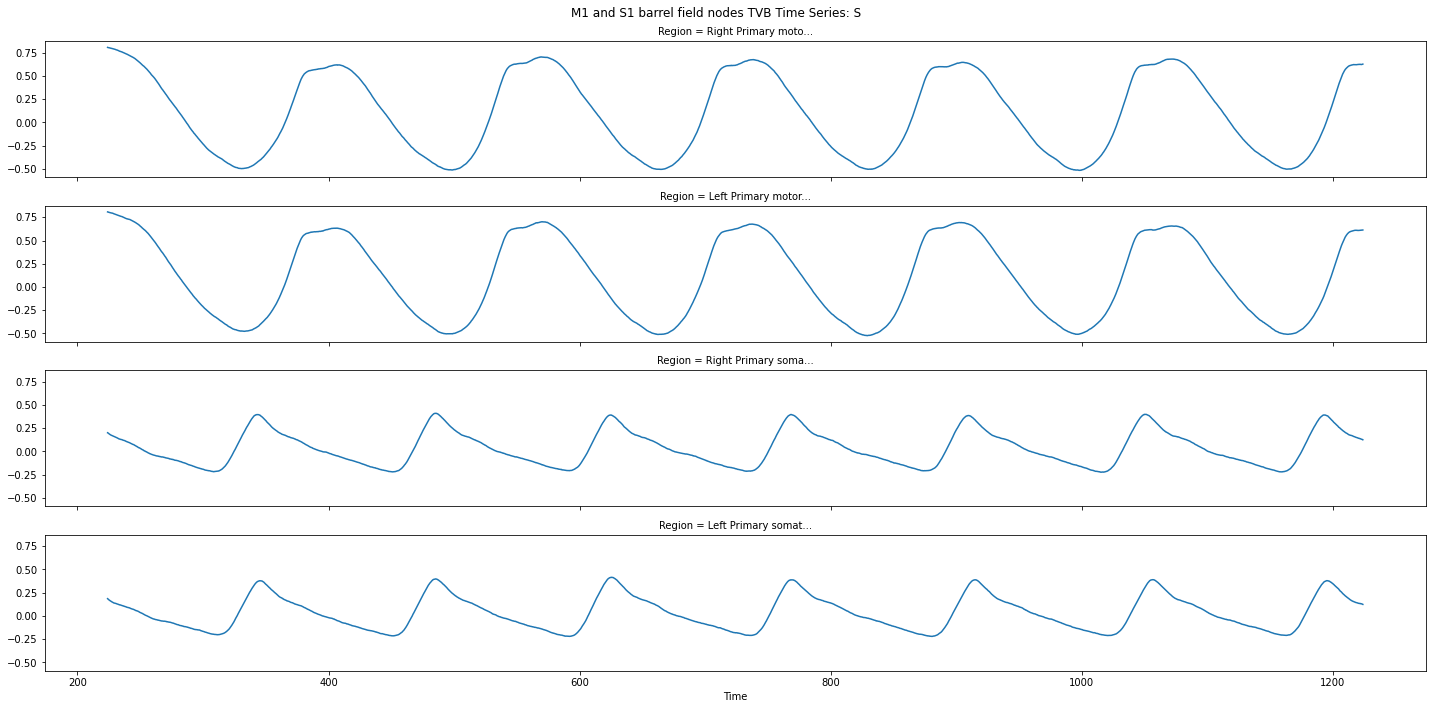

2022-02-04 16:46:19,597 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


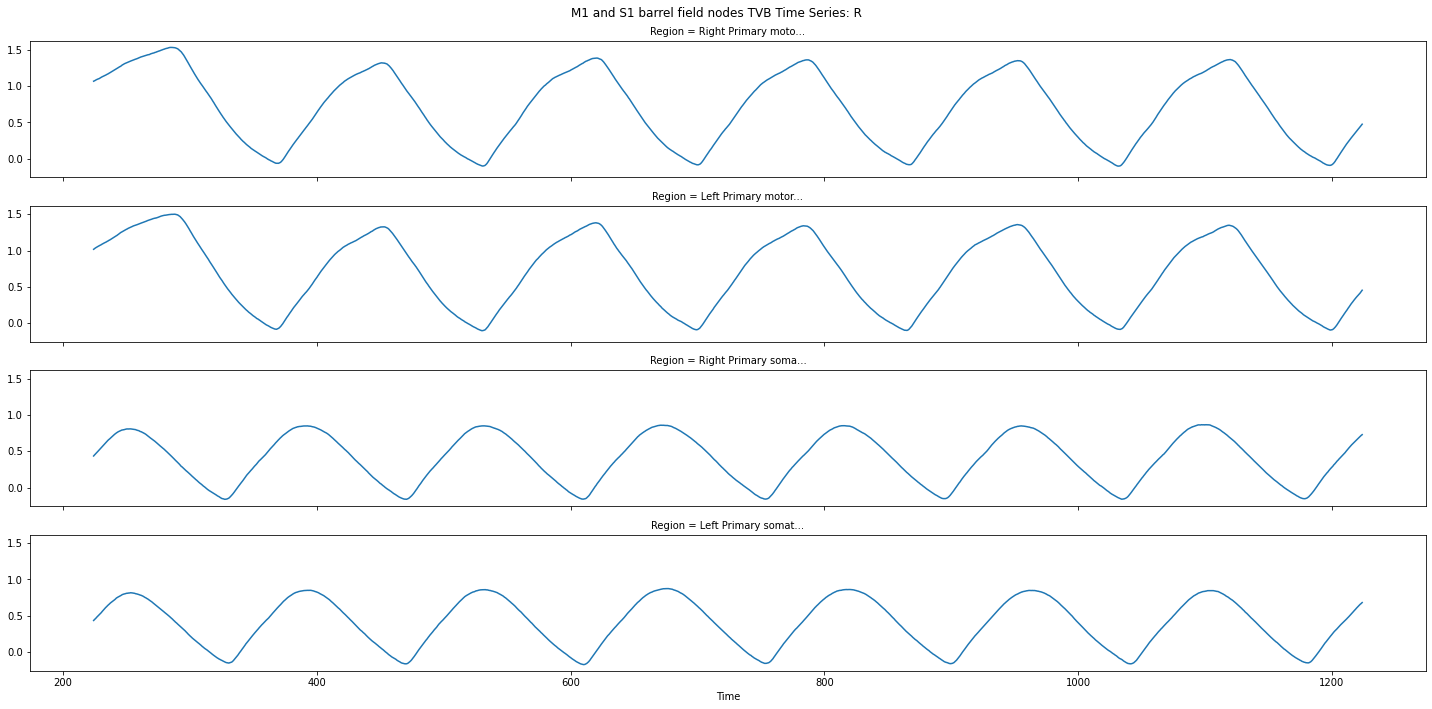

2022-02-04 16:46:20,420 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


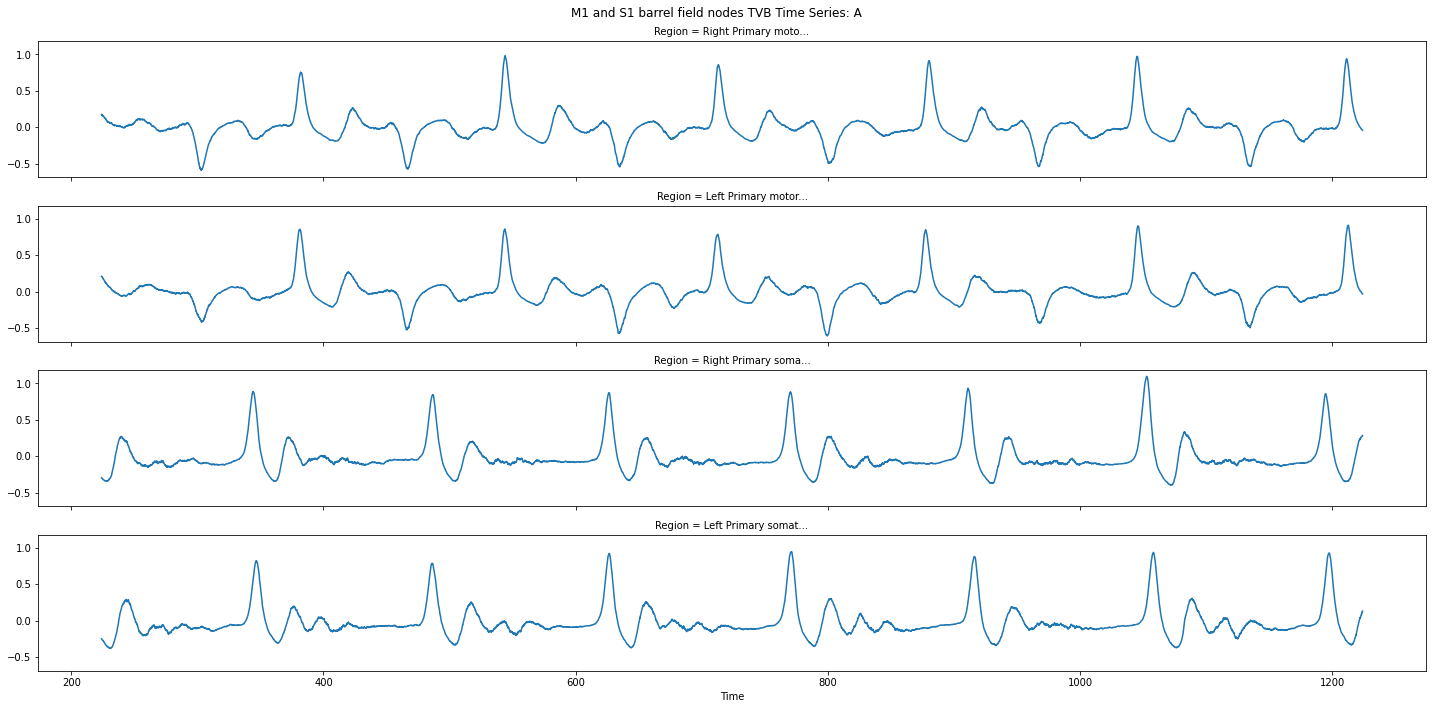

In [13]:
# Focus on the m1 and s1 barrel field nodes: 
if source_ts is not None:
    source_ts_m1s1brl = source_ts[-10000:, :, inds["m1s1brl"]]
    source_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series");

In [14]:
# Focus on the m1 and s1 barrel field nodes: raster plot
if source_ts is not None and source_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series Raster");

2022-02-04 16:46:21,277 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:21,297 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


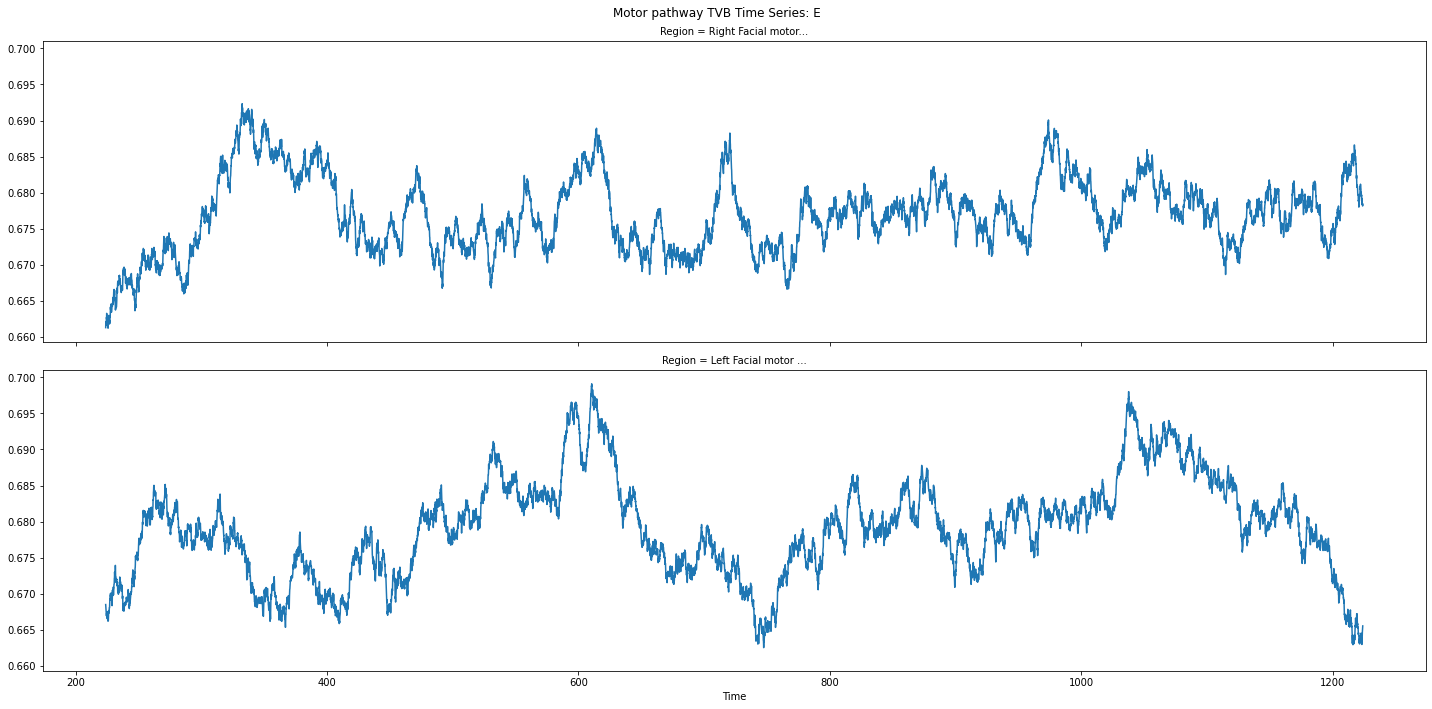

2022-02-04 16:46:21,838 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


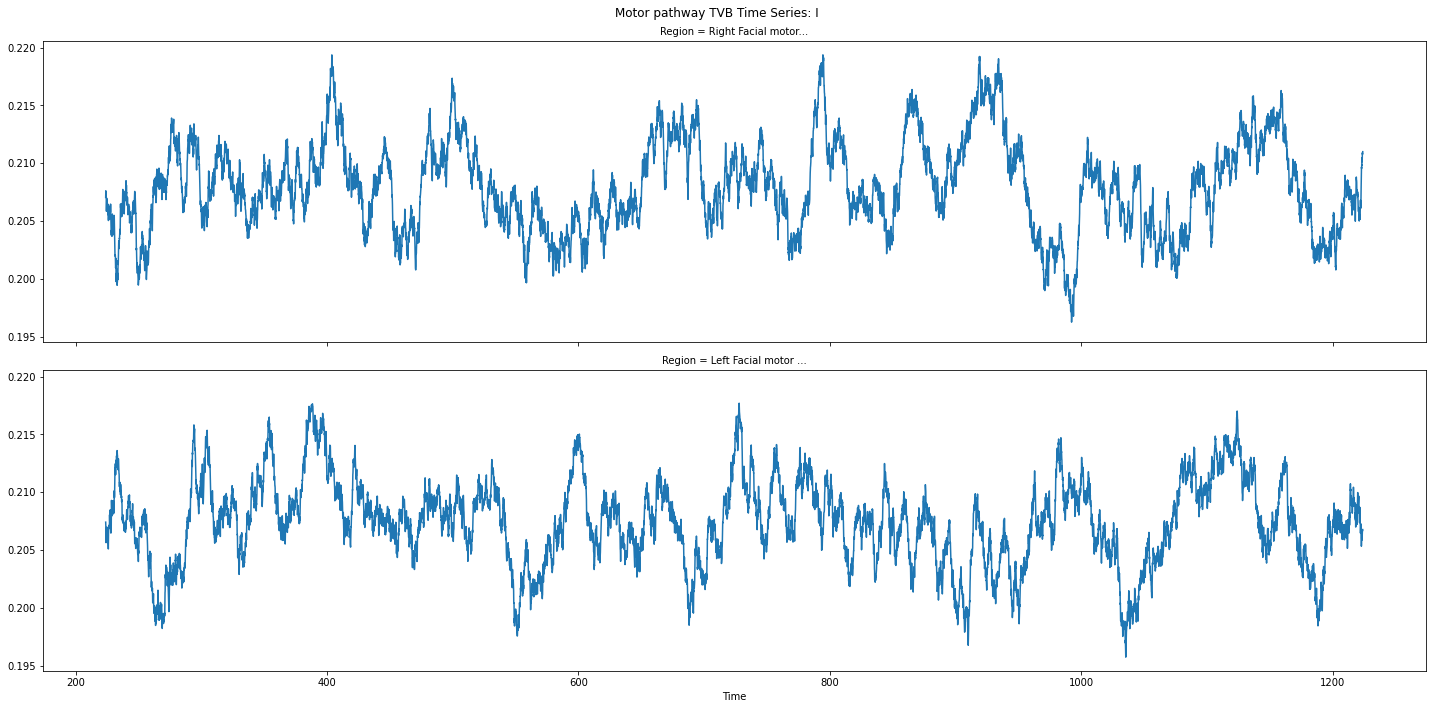

2022-02-04 16:46:22,376 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


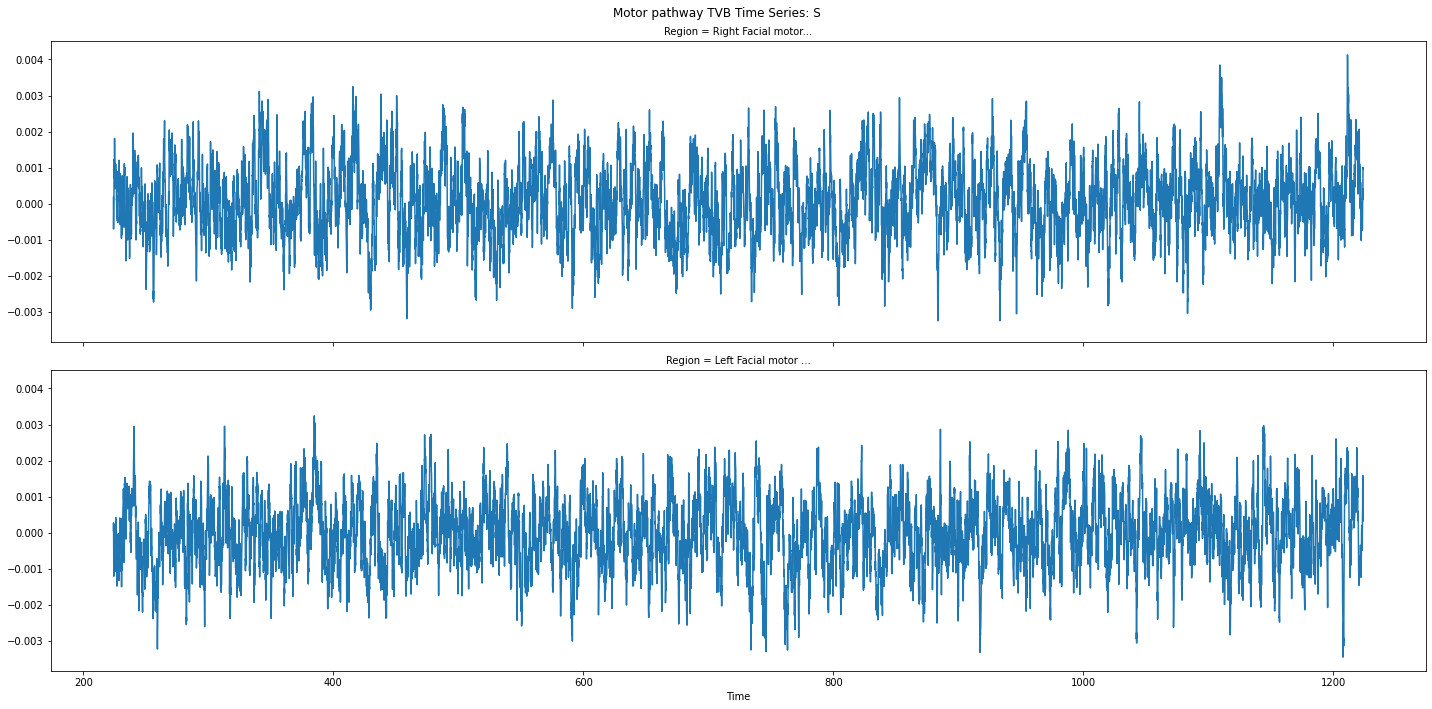

2022-02-04 16:46:23,082 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


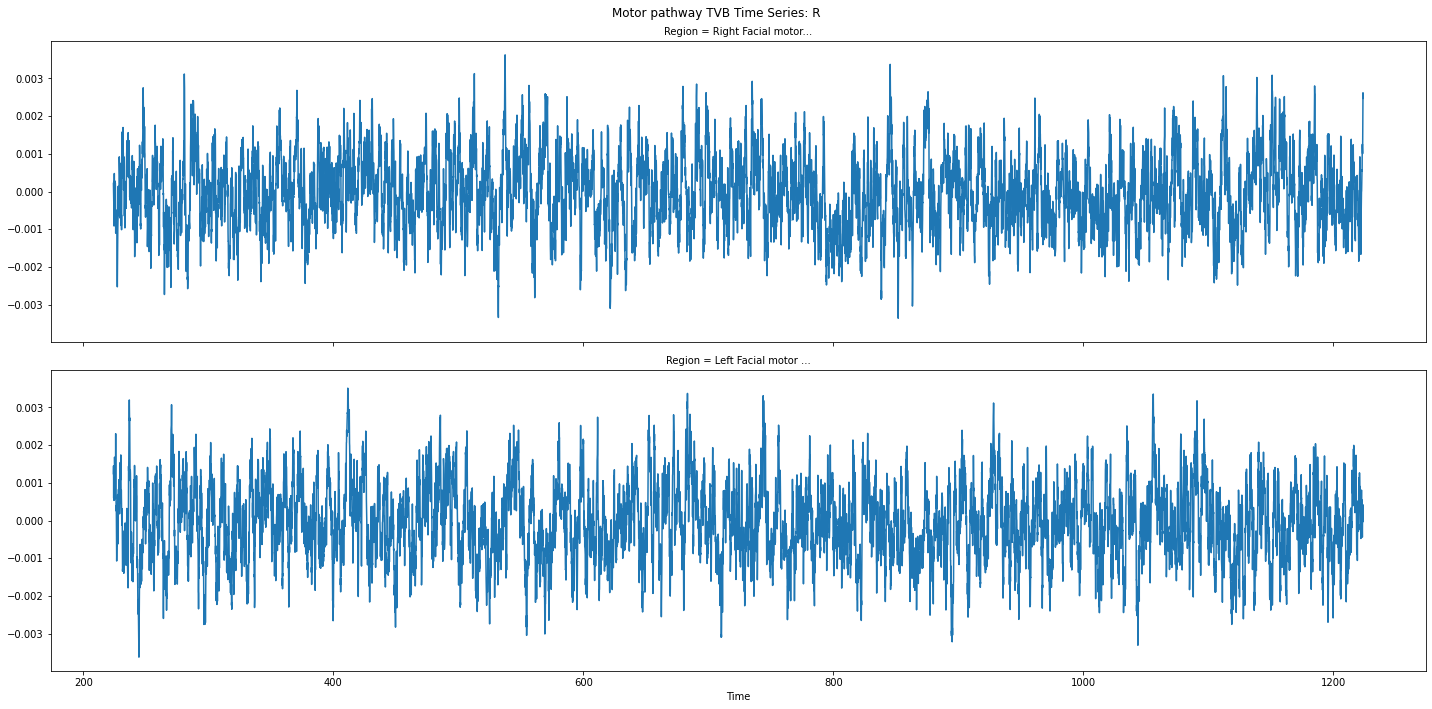

2022-02-04 16:46:23,838 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


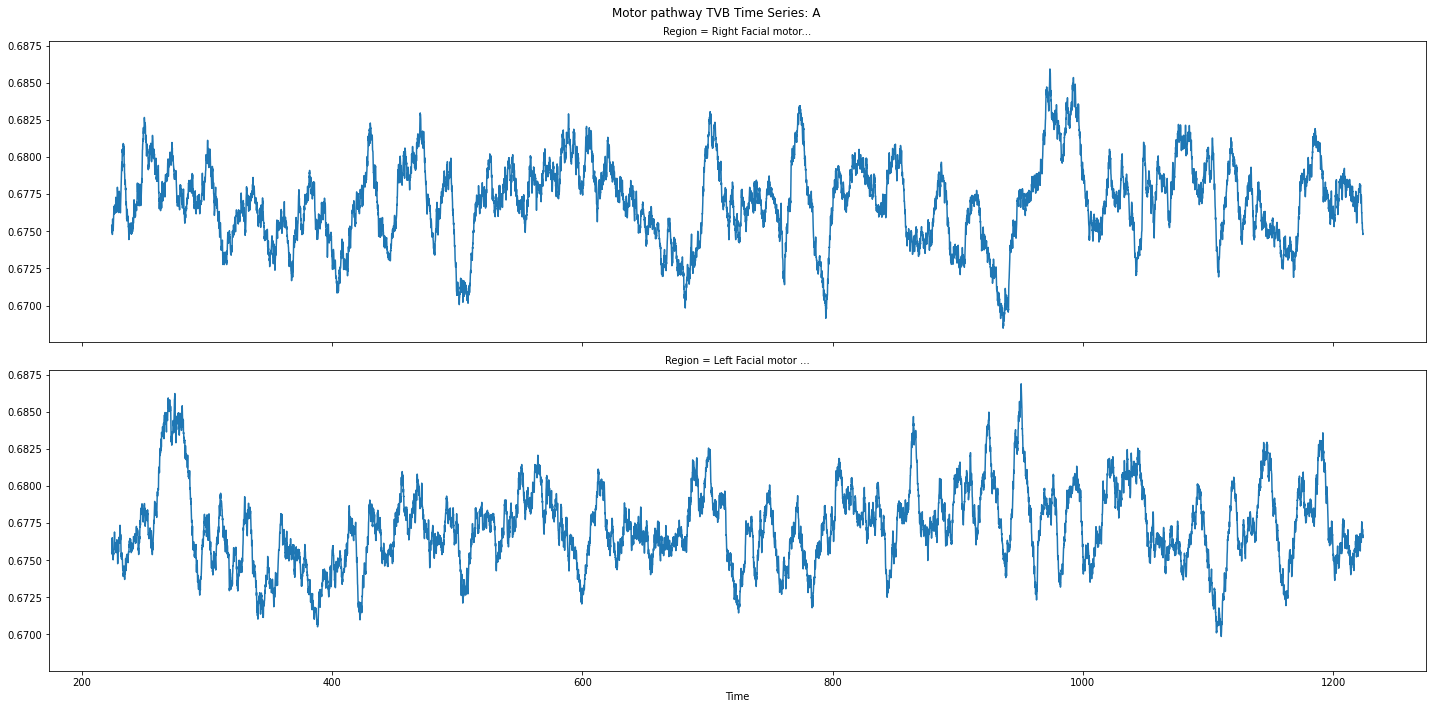

In [15]:
# Focus on the the motor pathway: 
if source_ts is not None:
    source_ts_motor = source_ts[-10000:, :, inds["motor"]]
    source_ts_motor.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_motor.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_motor.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Motor pathway TVB Time Series");

In [16]:
# Focus on the motor pathway: raster plot
if source_ts_motor is not None and source_ts_motor.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_motor.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_motor.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="Motor pathway TVB Time Series Raster");

2022-02-04 16:46:24,463 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:24,485 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


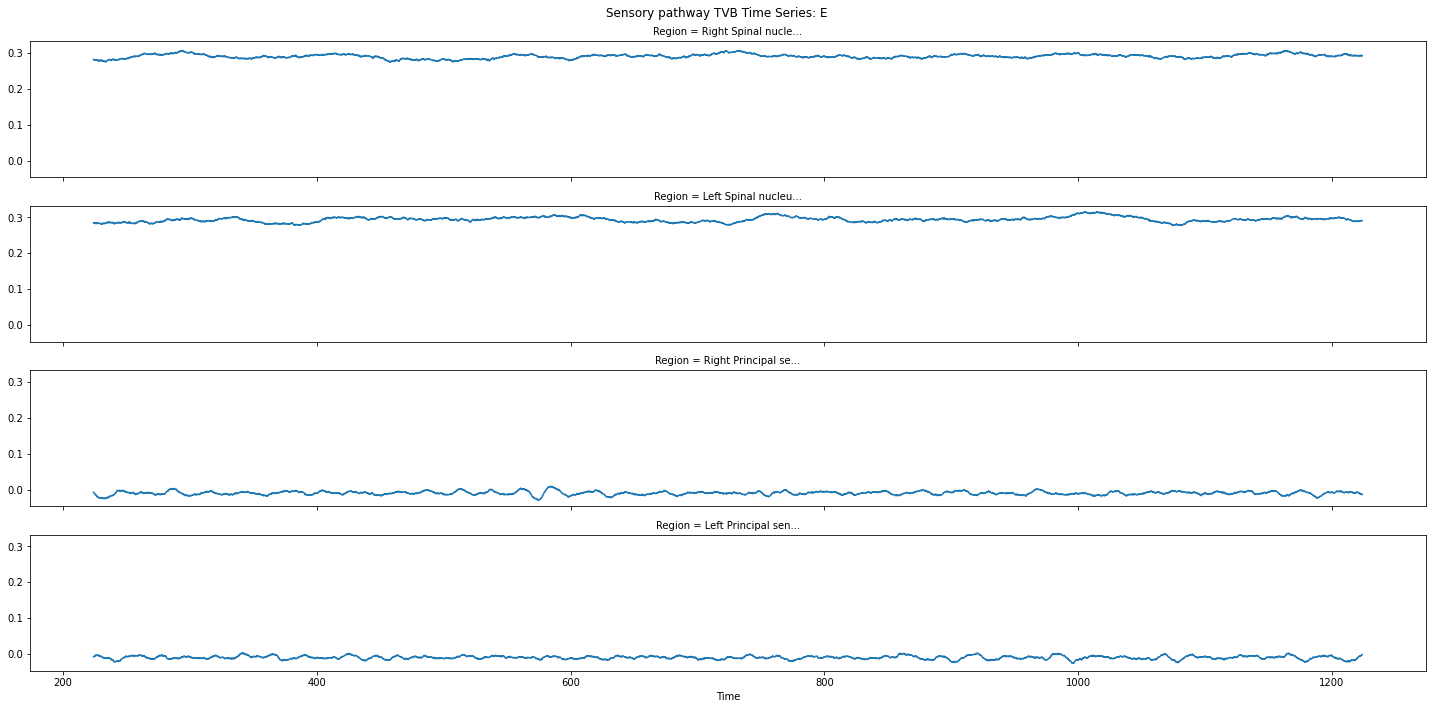

2022-02-04 16:46:25,190 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


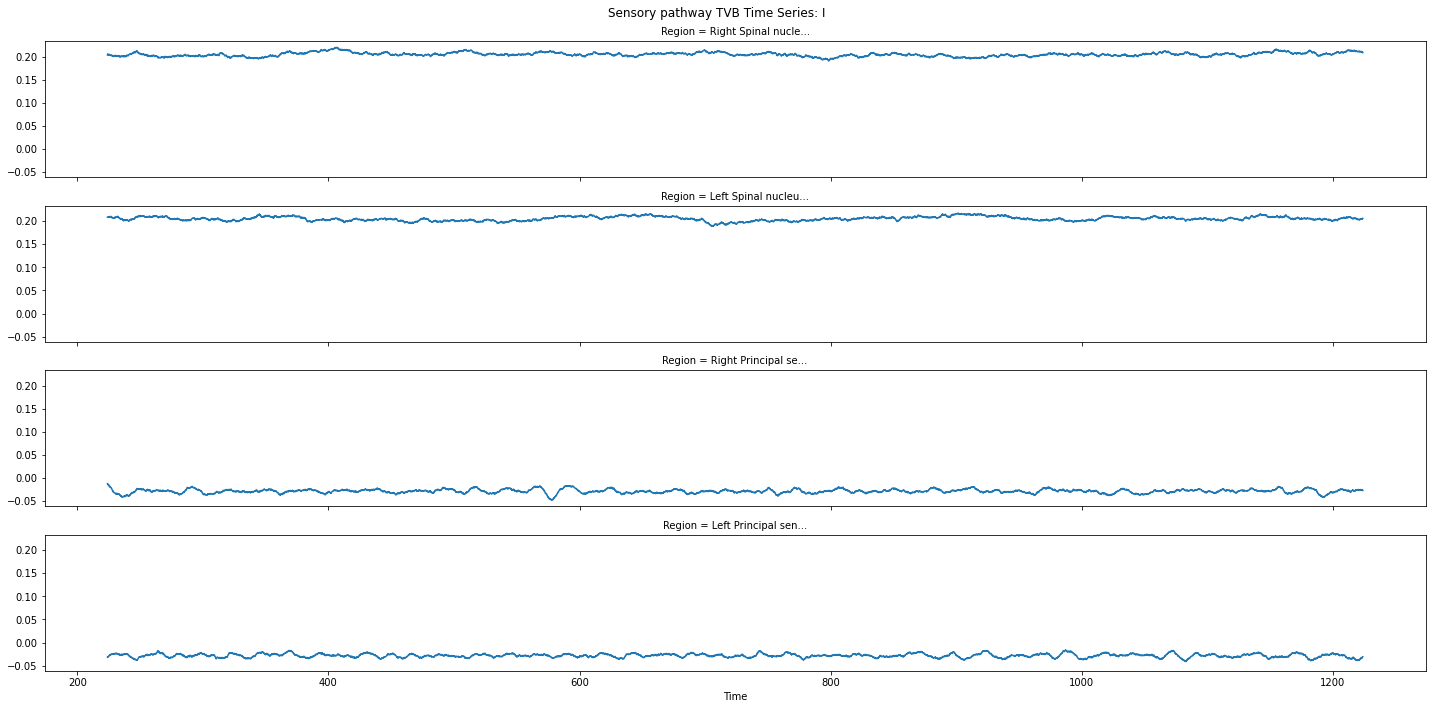

2022-02-04 16:46:25,906 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


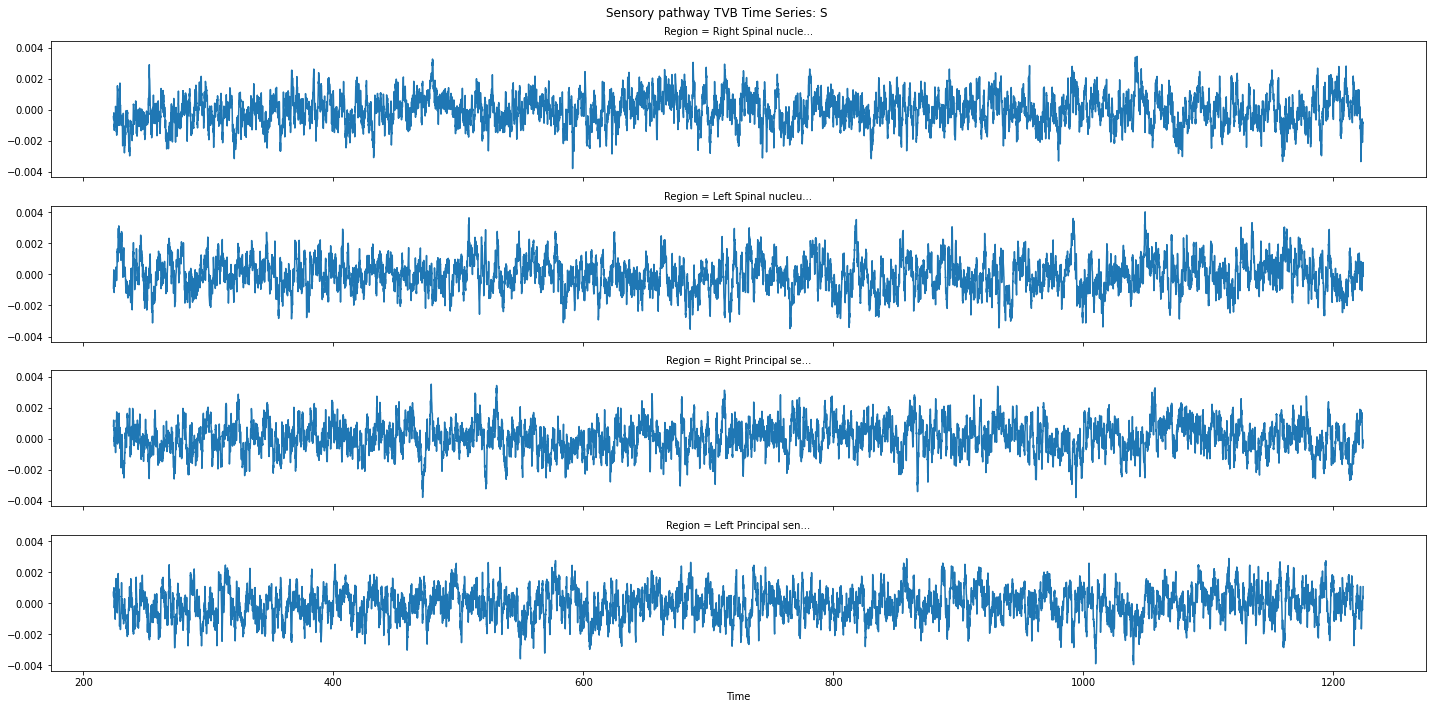

2022-02-04 16:46:26,898 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


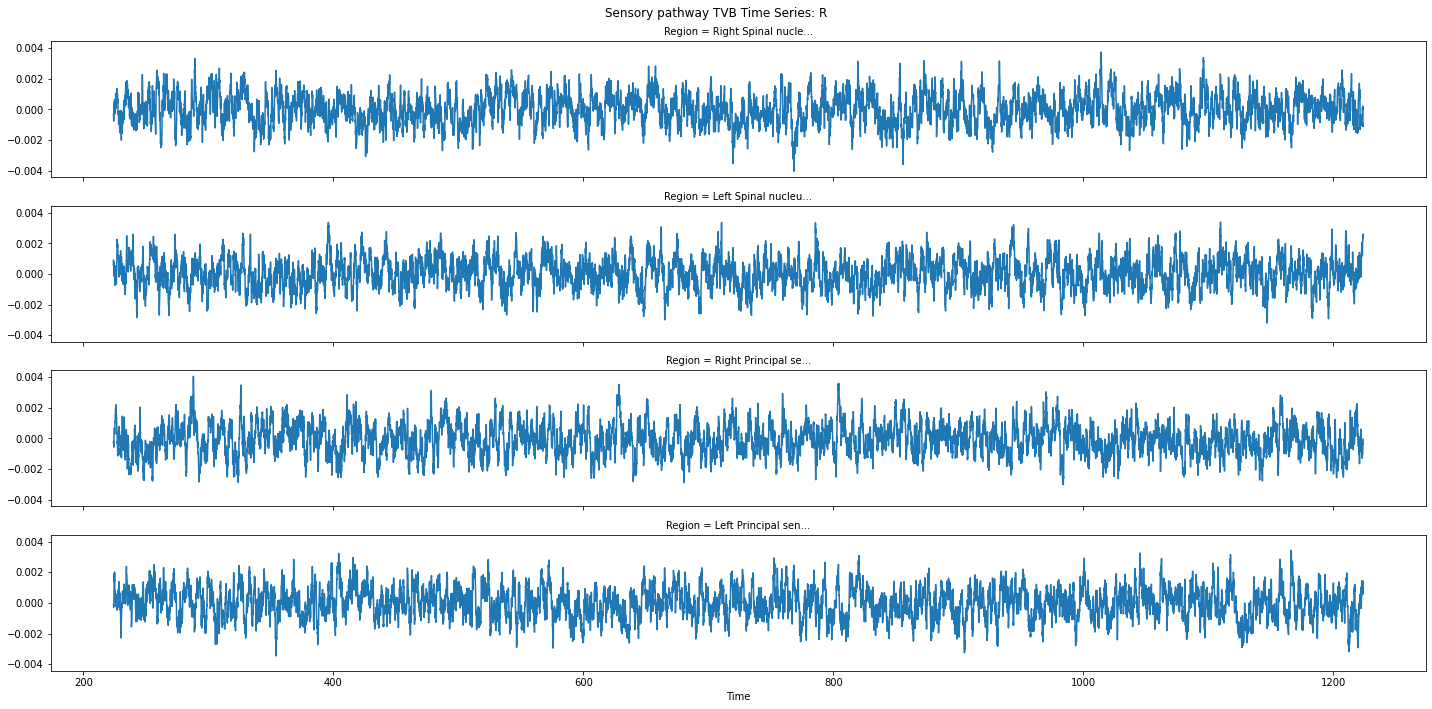

2022-02-04 16:46:27,860 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


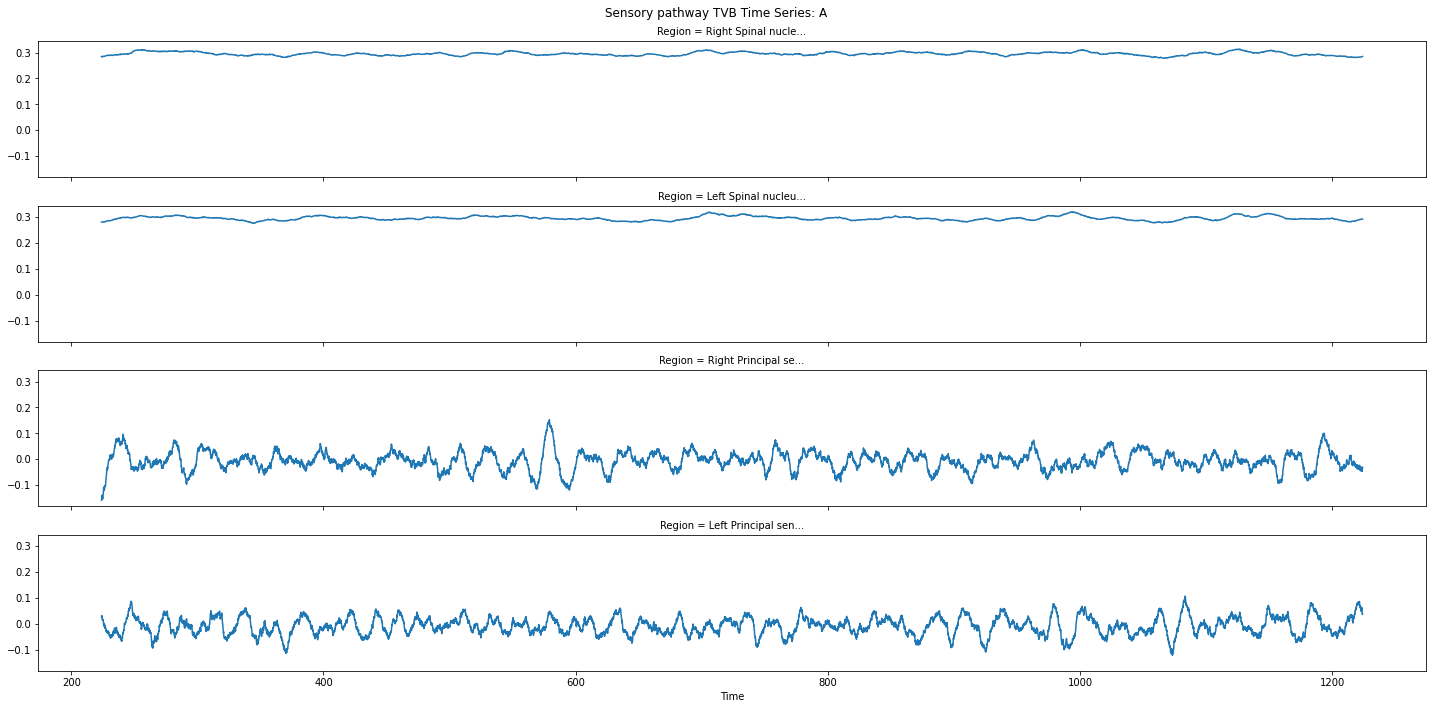

In [17]:
# Focus on the sensory pathway: 
if source_ts is not None:
    source_ts_sens = source_ts[-10000:, :, inds["sens"]]
    source_ts_sens.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_sens.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_sens.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Sensory pathway TVB Time Series");

In [18]:
# Focus on the sensory pathway: raster plot
if source_ts is not None and source_ts_sens.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_sens.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_sens.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Sensory pathway TVB Time Series Raster");

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


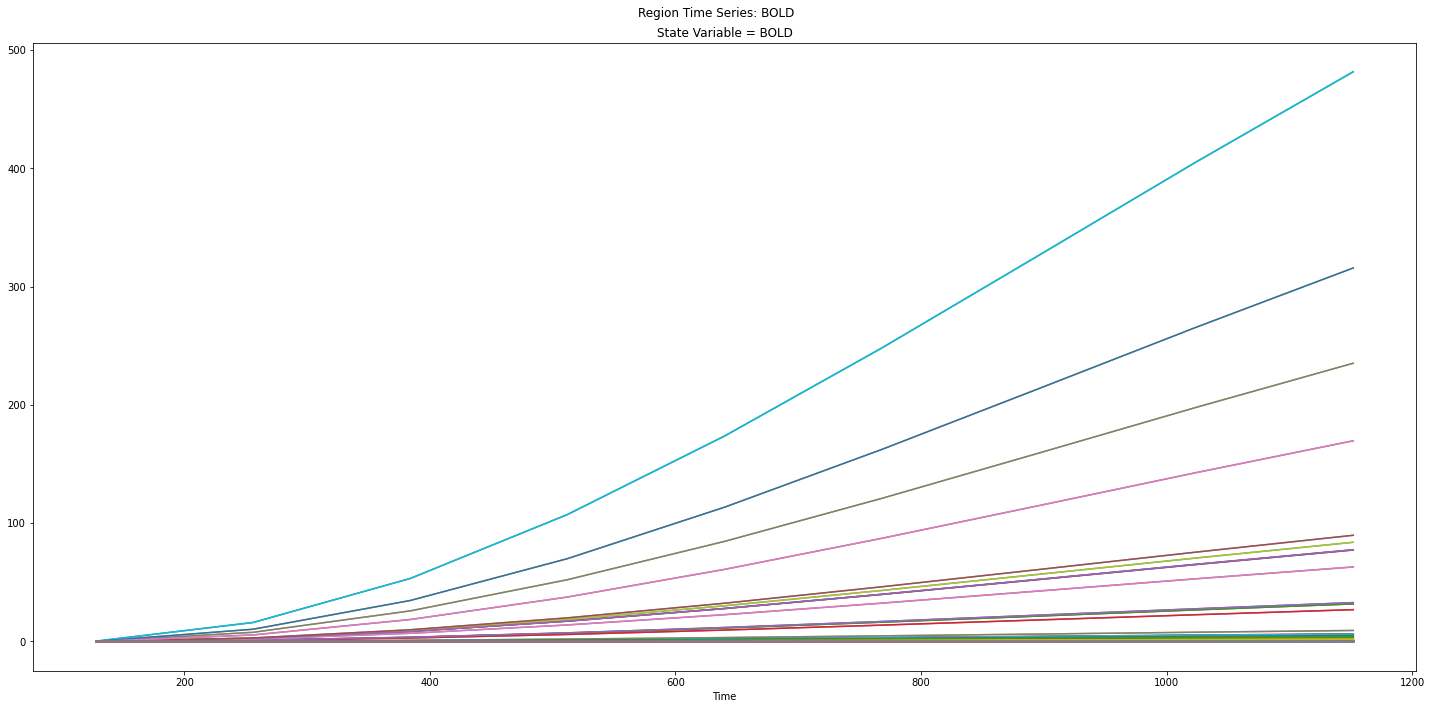

In [19]:
# bold_ts TVB time series
if bold_ts is not None:
    bold_ts.plot_timeseries(plotter_config=plotter.config, 
                            hue="Region" if bold_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                            per_variable=bold_ts.shape[1] > MAX_VARS_IN_COLS, 
                            figsize=FIGSIZE);

In [20]:
# # Focus on the m1 and s1 barrel field nodes: 
# if bold_ts is not None:
#     bold_ts_m1s1brl = bold_ts[-10000:, :, inds["m1s1brl"]]
#     bold_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
#                                     hue="Region" if bold_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                     per_variable=bold_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
#                                     figsize=FIGSIZE, figname="M1 and S1 barrel field nodes BOLD Time Series");

In [21]:
# # Focus on the m1 and s1 barrel field nodes: raster plot
# if bold_ts is not None and bold_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
#                                 per_variable=bold_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
#                                 figsize=FIGSIZE, figname="M1 and S1 barrel field nodes BOLD Time Series Raster");

In [22]:
# # Focus on the the motor pathway: 
# if bold_ts is not None:
#     bold_ts_motor = bold_ts[-10000:, :, inds["motor"]]
#     bold_ts_motor.plot_timeseries(plotter_config=plotter.config, 
#                                    hue="Region" if bold_ts_motor.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                    per_variable=bold_ts_motor.shape[1] > MAX_VARS_IN_COLS, 
#                                    figsize=FIGSIZE, figname="Motor pathway BOLD Time Series");

In [23]:
# # Focus on the motor pathway: raster plot
# if bold_ts is not None and bold_ts_motor.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_motor.plot_raster(plotter_config=plotter.config, 
#                               per_variable=bold_ts_motor.shape[1] > MAX_VARS_IN_COLS,
#                               figsize=FIGSIZE, figname="Motor pathway BOLD Time Series Raster");

In [24]:
# # Focus on the sensory pathway: 
# if bold_ts is not None:
#     bold_ts_sens = bold_ts[-10000:, :, inds["sens"]]
#     bold_ts_sens.plot_timeseries(plotter_config=plotter.config, 
#                                  hue="Region" if bold_ts_sens.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                  per_variable=bold_ts_sens.shape[1] > MAX_VARS_IN_COLS, 
#                                  figsize=FIGSIZE, figname="Sensory pathway BOLD Time Series");

In [25]:
# # Focus on the sensory pathway: raster plot
# if bold_ts is not None and bold_ts_sens.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_sens.plot_raster(plotter_config=plotter.config, 
#                              per_variable=bold_ts_sens.shape[1] > MAX_VARS_IN_COLS,
#                              figsize=FIGSIZE, figname="Sensory pathway BOLD Time Series Raster");

### Interactive time series plot

In [26]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

2022-02-04 16:46:29,268 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
data.shape = (10240, 1, 4, 1)
period = 0.1
window_length = 1000
max_freq = 5000
freq_step = 1
time_series_length = 1024


<IPython.core.display.Javascript object>


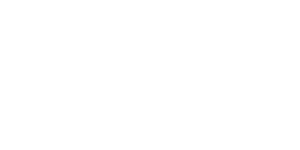

nseg = 
2
seg_tpts = 
10000
overlap = 
9760
frequency shape: (5000,)
spectra shape: (5000, 1, 4, 1)
spectra_norm shape: (5000, 1, 4, 1)
Frequency range for plotting: [0, 4999]


Text(value='', description='start:stop:step', placeholder='Regions Slicer')

Text(value='', description='f_min, f_max', placeholder='Frequency Range')

In [27]:
# For interactive plotting:
%matplotlib notebook  


from tvb.datatypes.time_series import TimeSeries
from tvb.contrib.scripts.plot.power_spectra_interactive import PowerSpectraInteractive

tsr = TimeSeries(data=source_ts[1000:, 0, inds["m1s1brl"]]._data.values, sample_period=source_ts.sample_period)
psi = PowerSpectraInteractive()
psi.time_series = tsr
psi.window_length = 1000.0
psi.show()
from ipywidgets import interact, widgets as ip_widgets
from IPython.display import display

textRegions = ip_widgets.Text(
    value='',
    placeholder='Regions Slicer',
    description='start:stop:step',
    disabled=False
)

textFreqs = ip_widgets.Text(
    value='',
    placeholder='Frequency Range',
    description='f_min, f_max',
    disabled=False
)

def callbackRegions(wdgt):
    # replace by something useful
    psi.update_regions(wdgt.value)

def callbackFreqs(wdgt):
    # replace by something useful
    psi.update_freq_range(wdgt.value)
    
textRegions.on_submit(callbackRegions)
textFreqs.on_submit(callbackFreqs)

display(textRegions)
display(textFreqs)



2022-02-04 16:46:29,830 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


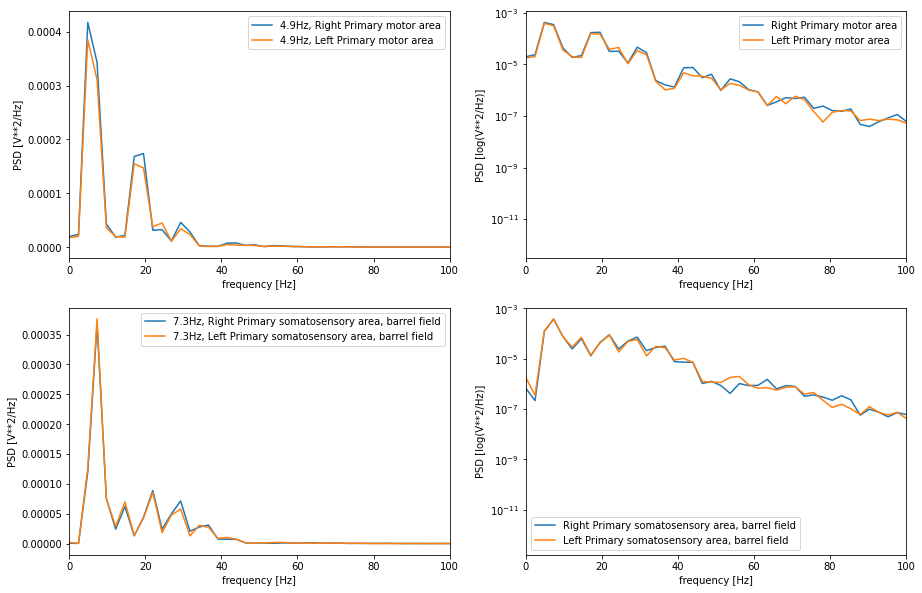

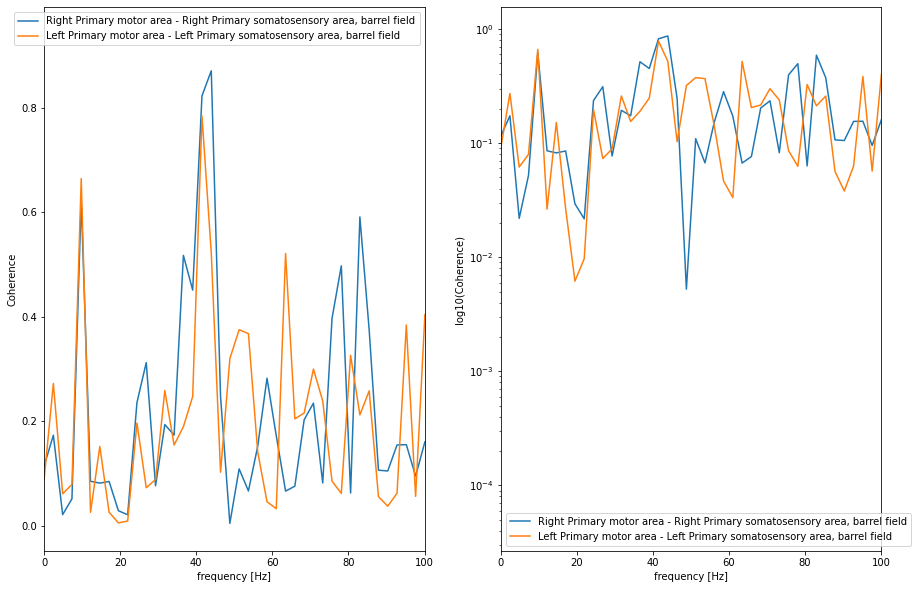

In [28]:
%matplotlib inline

from examples.tvb_nest.notebooks.cerebellum.utils import  compute_plot_selected_spectra_coherence, compute_plot_ica

NPERSEG = np.array([256, 512, 1024, 2048, 4096])
NPERSEG = NPERSEG[np.argmin(np.abs(NPERSEG - (source_ts.shape[0]-transient/dt)))]

# Power Spectra and Coherence for M1 - S1 barrel field
compute_plot_selected_spectra_coherence(source_ts, inds["m1s1brl"], 
                                        transient=transient, nperseg=NPERSEG, fmin=0.0, fmax=100.0)

2022-02-04 16:46:31,314 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


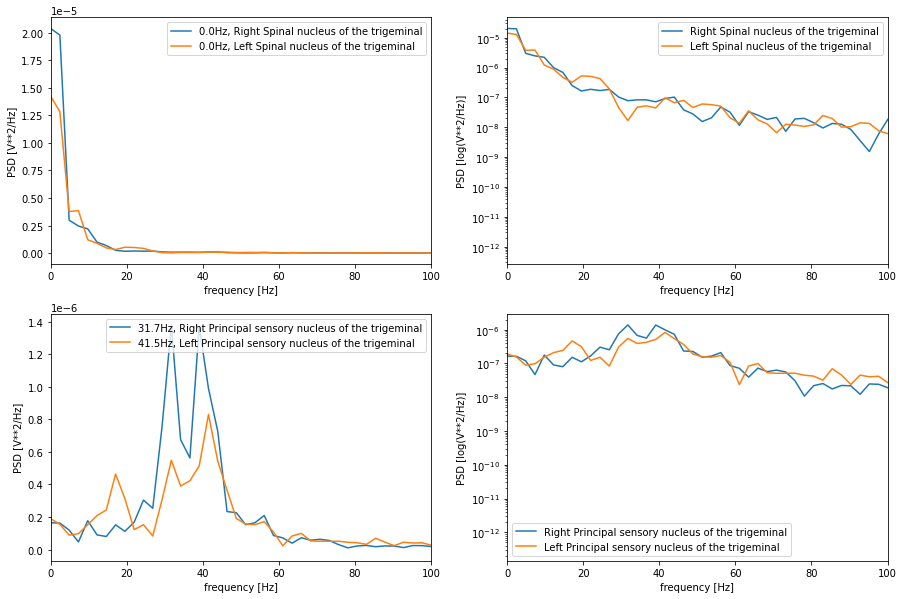

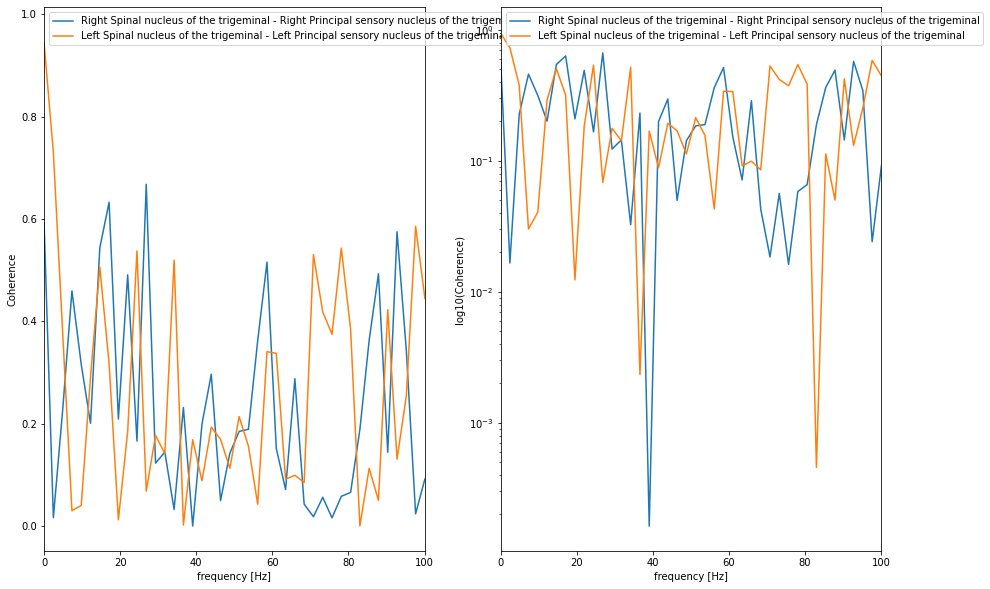

In [29]:
# Power Spectra and Coherence along the sensory pathway:
# for Medulla SPV, Sensory PONS
compute_plot_selected_spectra_coherence(source_ts, inds["sens"], 
                                        transient=transient, nperseg=NPERSEG, fmin=0.0, fmax=100.0)

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


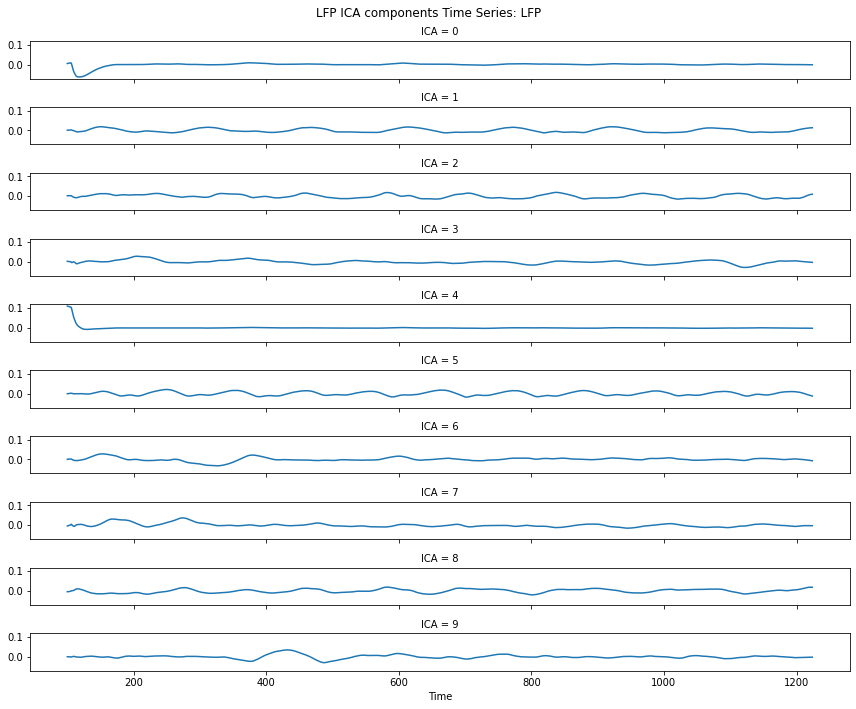

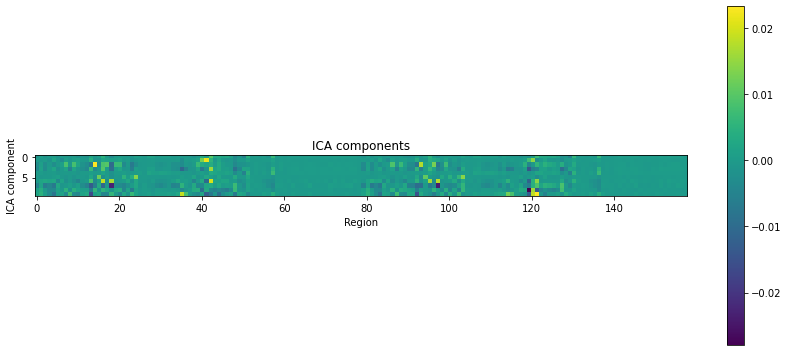

In [30]:
plotter.config.DEFAULT_SIZE = (12, 10)  # FIGSIZE
if source_ts is not None:
    # LFP (E) ICA:
    lfp_ica_comps, lfp_ics_ts, lfp_ica = compute_plot_ica(source_ts[transient:].data[:, 0, :, 0].squeeze(), 
                                                          source_ts[transient:].time,
                                                          variable="LFP", n_components=10, plotter=plotter)
    

In [31]:
# if bold_ts is not None:    
#     # BOLD ICA:
#     bold_ica_comps, bold_ics_ts, bold_ica = compute_plot_ica(bold_ts.data[:, 0, :, 0].squeeze(), bold_ts.time,
#                                                              variable="BOLD", n_components=10, plotter=plotter)
    

(11240, 86)


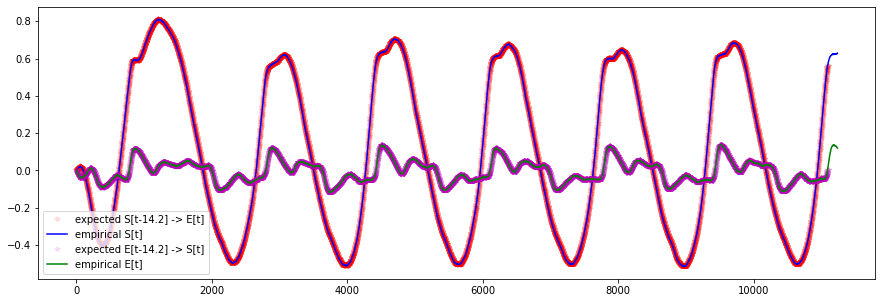

In [32]:
if TEST:
    import matplotlib.pyplot as plt 

    # Checking that internal time delays work as expected:
    SC_dels = np.concatenate(simulator.model._SC_dels, -1).T
    ET_dels = np.concatenate(simulator.model._ET_dels, -1).T
    print(SC_dels.shape)
    plt.figure(figsize=(15, 5))
    d = simulator.model.tau_ct[1]
    idel = int(np.round(d/simulator.integrator.dt))
    plt.plot(SC_dels[idel+1:, 1], 'r*', alpha=0.1, label='expected S[t-%g] -> E[t]' % d)
    plt.plot(source_ts.data[:, 2, 1, 0], 'b', label='empirical S[t]')
    plt.plot(ET_dels[idel+1:, 1], 'm*', alpha=0.1, label='expected E[t-%g] -> S[t]' % d)
    plt.plot(source_ts.data[:, 0, 1, 0], 'g', label='empirical E[t]')
    plt.legend()


(11240, 86)


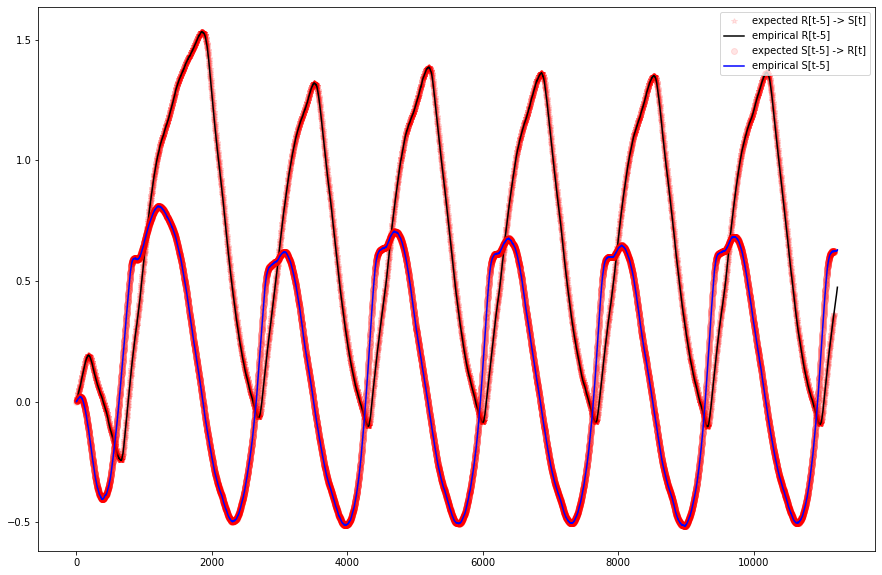

In [33]:
if TEST:
    # Checking that internal time delays work as expected:
    RS_dels = np.concatenate(simulator.model._RS_dels, -1).T
    SR_dels = np.concatenate(simulator.model._SR_dels, -1).T
    print(RS_dels.shape)
    plt.figure(figsize=(15, 10))
    plt.plot(RS_dels[51:, 1], 'r*', label='expected R[t-5] -> S[t]', alpha=.1)
    plt.plot(source_ts.data[:, 3, 1, 0], 'k', label='empirical R[t-5]')
    plt.plot(SR_dels[51:, 1], 'ro', label='expected S[t-5] -> R[t]', alpha=.1)
    plt.plot(source_ts.data[:, 2, 1, 0], 'b',label='empirical S[t-5]')
    plt.legend()

2022-02-04 16:46:36,317 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:36,334 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:36,350 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:36,367 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:36,382 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:36,401 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-02-04 16:46:36,417 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

<IPython.core.display.Javascript object>


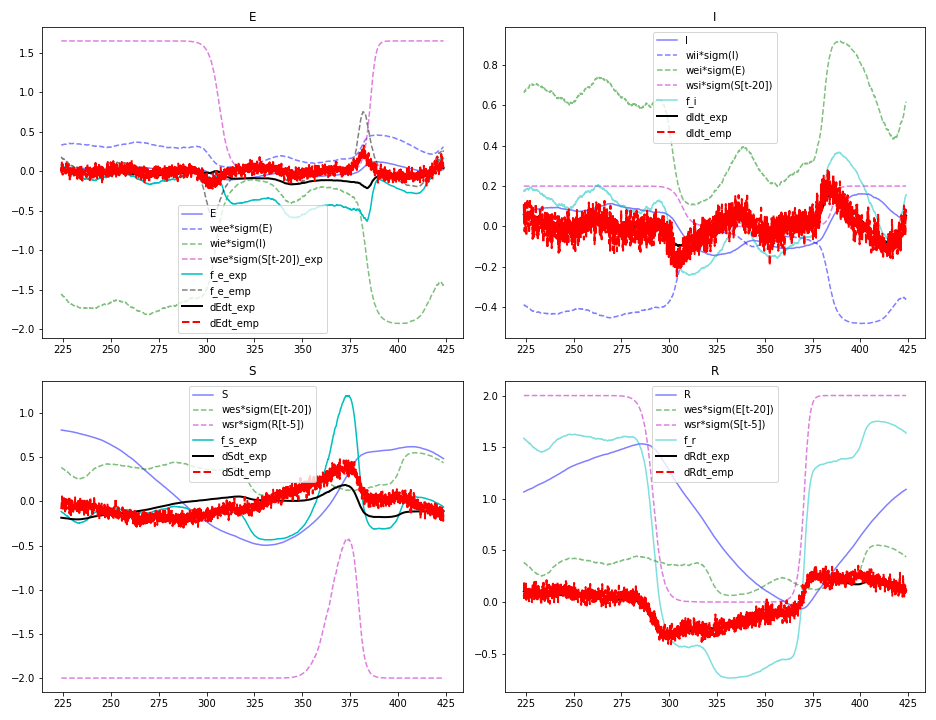

In [34]:
%matplotlib notebook

def test(source_ts, inds, cth=None, Io=0.0, transient=10000, 
         wee=1.4 if DEMO else 0.5, 
         wei = 1.4 if DEMO else 1.0, 
         wie = -3. if DEMO else -2.0, 
         wii = -0.5, # wie = -2.,wii = -0.5,
         wertn = 0.6,
         weth =  .6,
         wthe = 1.65, # 1.65,
         wthi = 0.2,
         wrtnth = -2.,
         wthrtn = 2.,
         # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2:
         a_e = 0.9 if DEMO else 0.3,  
         a_i = 0.9 if DEMO else 0.5, 
         a_th=0.25 if DEMO else 0.2, 
         a_rtn=0.25 if DEMO else 0.2, 
         i_e = -0.35,
         i_i = -0.3,
         i_th = 0.5,
         i_rtn = -0.8
        ):
    
    # Neuronal response function
    def f(u,gain=20.0,threshold=0.0):
        output= 1./(1.+np.exp(-gain*(u-threshold))); 
        return output 
    
    mind = inds["m1s1brl"][0]
    e = source_ts[-transient:-transient+2000, [0], mind].data.squeeze()
    i = source_ts[-transient:-transient+2000, [1], mind].data.squeeze()
    fe2 = source_ts[-transient:-transient+2000, [4], mind].data.squeeze()
    s = source_ts[-transient:-transient+2000, [2], mind].data.squeeze()
    r = source_ts[-transient:-transient+2000, [3], mind].data.squeeze()
    t = source_ts[-transient:-transient+2000, [0], mind].time
    e_sigm = f(e)
    i_sigm = f(i)
    # Delayed s by tau_ct = 20
    sd_ct = source_ts[-transient-200:-transient+2000-200, [2], mind].data.squeeze()
    sd_ct_sigm = f(sd_ct)
        
    # Delayed e by tau_ct = 20
    ed = source_ts[-transient-200:-transient+2000-200, [0], mind].data.squeeze()
    ed_sigm = f(ed)
    # Delayed s by tau_tt = 5
    sd_tt = source_ts[-transient-50:-transient+2000-50, [2], mind].data.squeeze()
    sd_tt_sigm = f(sd_tt)
    # Delayed r by tau_tt = 5
    rd_tt = source_ts[-transient-50:-transient+2000-50, [3], mind].data.squeeze()
    rd_tt_sigm = f(rd_tt)
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 10))
    alpha = 0.5
    lw = 2.0
    
    # dedt:
    ee = wee*e_sigm # 1.4
    ie = wie*i_sigm # -3.0
    se = wthe*sd_ct_sigm  # 1.65
    fe = ee + ie + se + i_e
    dedt = a_e*(-e + fe) 
    dedt2 = np.diff(e) / 0.1 / 0.1 
    axes[0, 0].plot(t, e, "b", label="E", alpha=alpha)
    axes[0, 0].plot(t, ee, "b--", label="wee*sigm(E)", alpha=alpha)
    axes[0, 0].plot(t, ie, "g--", label="wie*sigm(I)", alpha=alpha)
    if cth is not None:
        sd_ct_sigm2 = cth[-transient:-transient+2000, 0]
        se2 = wthe*sd_ct_sigm2
        axes[0, 0].plot(t, se2, "k", label="wse*sigm(S[t-20])_emp", alpha=alpha)
    axes[0, 0].plot(t, se, "m--", label="wse*sigm(S[t-20])_exp", alpha=alpha)
    axes[0, 0].plot(t, fe, "c", label="f_e_exp")  # , alpha=alpha
    axes[0, 0].plot(t, fe2, "k--", label="f_e_emp", alpha=alpha) # 
    axes[0, 0].plot(t, dedt, "k", label="dEdt_exp", linewidth=lw)
    axes[0, 0].plot(t[:-1], dedt2, 'r--', label="dEdt_emp", linewidth=lw)
    axes[0, 0].legend()
    axes[0, 0].set_title("E")
    
    # didt:
    ie = wei*e_sigm # 1.4
    ii = wii*i_sigm # -0.5
    si = wthi * sd_ct_sigm  # 0.2
    fi = ie + ii + si + i_i
    didt = a_i*(-i + fi) 
    didt2 = np.diff(i) / 0.1 / 0.1 
    axes[0, 1].plot(t, i, "b", label="I", alpha=alpha)
    axes[0, 1].plot(t, ii, "b--", label="wii*sigm(I)", alpha=alpha)
    axes[0, 1].plot(t, ie, "g--", label="wei*sigm(E)", alpha=alpha)
    axes[0, 1].plot(t, si, "m--", label="wsi*sigm(S[t-20])", alpha=alpha)
    axes[0, 1].plot(t, fi, "c", label="f_i", alpha=alpha)
    axes[0, 1].plot(t, didt, "k", label="dIdt_exp", linewidth=lw)
    axes[0, 1].plot(t[:-1], didt2, 'r--', label="dIdt_emp", linewidth=lw)
    axes[0, 1].legend()
    axes[0, 1].set_title("I")
    
    # dsdt:
    es = weth * ed_sigm
    rs = wrtnth * rd_tt_sigm
    fs = es + rs + i_th + Io
    dsdt = a_th*(-s + fs)
    dsdt2 = np.diff(s) / 0.1 / 0.1
    axes[1, 0].plot(t, s, "b", label="S", alpha=alpha)
    axes[1, 0].plot(t, es, "g--", label="wes*sigm(E[t-20])", alpha=alpha)
    axes[1, 0].plot(t, rs, "m--", label="wsr*sigm(R[t-5])", alpha=alpha)
    axes[1, 0].plot(t, fs, "c", label="f_s_exp")  # , alpha=alpha
    axes[1, 0].plot(t, dsdt, "k", label="dSdt_exp", linewidth=lw)
    axes[1, 0].plot(t[:-1], dsdt2, 'r--', label="dSdt_emp", linewidth=lw)
    axes[1, 0].legend()
    axes[1, 0].set_title("S")
    
    # drdt:
    er = wertn * ed_sigm
    sr = wthrtn * sd_tt_sigm
    fr = er + sr + i_rtn
    drdt = a_rtn*(-r + fr) 
    drdt2 = np.diff(r) / 0.1 / 0.1 
    axes[1, 1].plot(t, r, "b", label="R", alpha=alpha)
    axes[1, 1].plot(t, er, "g--", label="wes*sigm(E[t-20])", alpha=alpha)
    axes[1, 1].plot(t, sr, "m--", label="wsr*sigm(S[t-5])", alpha=alpha)
    axes[1, 1].plot(t, fr, "c", label="f_r", alpha=alpha)
    axes[1, 1].plot(t, drdt, "k", label="dRdt_exp", linewidth=lw)
    axes[1, 1].plot(t[:-1], drdt2, 'r--', label="dRdt_emp", linewidth=lw)
    axes[1, 1].legend()
    axes[1, 1].set_title("R")
    
    fig.tight_layout()

if TEST:
    test(source_ts, inds, Io=I_o)

# References

1 Sanz Leon P, Knock SA , Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK. 2013. <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling and multimodal neuroimaging. <br>
  Brain Connectivity 3:121–145. <br>

3 Griffiths JD, McIntosh AR, Lefebvre J. 2020.   <br>
  A Connectome-Based, Corticothalamic Model of State- <br>
  and Stimulation-Dependent Modulation of Rhythmic Neural Activity and Connectivity <br>
  Frontiers in Computational Neuroscience (vol. 14. doi: 10.3389/fncom.2020.575143) <br>
  https://www.frontiersin.org/articles/10.3389/fncom.2020.575143/full#h12
  
4 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>